## Monthly indicies model with ensemble and tunning

In [1]:
# Import packages 
import os 
import numpy as np
import pandas as pd
import xarray as xr
os.chdir('/Users/kaushalk/Desktop/open_projects/Telengana_Crop_Health/')
# Add the 'src' directory to the Python path
from src.process_data import compute_indices_for_df, prepare_model_data
from src.visualize import plot_numerical_distributions, plot_confusion_matrix

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, f1_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [3]:
def prepare_training_data(qtr_file: str, indices_file: str, target_substrings=None, columns_to_drop=None):
    """
    Prepare the final dataset for model training and testing.

    Parameters:
    - qtr_file (str): Path to the quarter index file (e.g., 'train_qtr_indx.csv').
    - indices_file (str): Path to the indices file (e.g., 'training_s2_indices_v1.csv').
    - target_substrings (list): List of substrings to identify columns for mean calculation.
    - columns_to_drop (list): List of columns to drop from the final dataset.

    Returns:
    - pd.DataFrame: Preprocessed DataFrame ready for model training.
    """
    # Default parameters
    if target_substrings is None:
        target_substrings = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8']
    if columns_to_drop is None:
        columns_to_drop = ['FarmID', 'State', 'District', 'Sub-District', 
                           'SDate', 'HDate', 'geometry', 'tif_path']

    # Load data
    qdf = pd.read_csv(qtr_file, index_col=0)
    idf = pd.read_csv(indices_file, index_col=0)

    # Merge data on 'FarmID'
    df = pd.merge(idf, qdf, on="FarmID", how="inner", suffixes=('', '_drop'))
    df = df.loc[:, ~df.columns.str.endswith('_drop')]  # Drop duplicate columns

    # Calculate mean for columns matching the target substrings
    column_suffixes = {col.split('_', 1)[1] for col in df.columns if any(sub in col for sub in target_substrings)}
    for suffix in column_suffixes:
        matching_columns = [col for col in df.columns if suffix in col and any(sub in col for sub in target_substrings)]
        df[f"M_ALL_{suffix}"] = df[matching_columns].mean(axis=1)

    # Drop columns from M4 to M8 after mean calculation
    df = df.drop(columns=[col for col in df.columns if any(sub in col for sub in target_substrings)])

    # Preprocess date columns and compute time difference
    df['SDate'] = pd.to_datetime(df['SDate'])
    df['HDate'] = pd.to_datetime(df['HDate'])
    df['TDays'] = (df['HDate'] - df['SDate']).dt.days

    # Drop unnecessary columns
    df = df.drop(columns=columns_to_drop, errors='ignore')

    # Drop columns containing "M_ALL"
    df = df.iloc[:, ~df.columns.str.contains("M_ALL")]
    df = df.iloc[:, ~df.columns.str.contains("M2_")]

    # Prepare final dataset
    train_df = prepare_model_data(df)

    return train_df

## Indices Stats for timeseries data 

def prepare_indeces_data_stats(qtr_file: str, indices_file: str, target_substrings=None, columns_to_drop=None):
    """
    Prepare the final dataset for model training and testing with enhanced statistical features.

    Parameters:
    - qtr_file (str): Path to the quarter index file (e.g., 'train_qtr_indx.csv').
    - indices_file (str): Path to the indices file (e.g., 'training_s2_indices_v1.csv').
    - target_substrings (list): List of substrings to identify columns for statistical calculations.
    - columns_to_drop (list): List of columns to drop from the final dataset.

    Returns:
    - pd.DataFrame: Preprocessed DataFrame ready for model training.
    """
    # Default parameters
    if target_substrings is None:
        target_substrings = ['M1', 'M2', 'M3', 'M4', 'M5','M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 'M14', 
                              'M15', 'M16', 'M17', 'M18', 'M19', 'M20', 'M21', 'M22', 'M23']
    if columns_to_drop is None:
        columns_to_drop = ['FarmID', 'State', 'District', 'Sub-District', 
                           'SDate', 'HDate', 'geometry', 'tif_path']

    # Load data
    qdf = pd.read_csv(qtr_file, index_col=0)
    idf = pd.read_csv(indices_file, index_col=0)

    # Merge data on 'FarmID'
    df = pd.merge(idf, qdf, on="FarmID", how="inner", suffixes=('', '_drop'))
    df = df.loc[:, ~df.columns.str.endswith('_drop')]  # Drop duplicate columns
    # Preprocess date columns and compute time difference
    df['SDate'] = pd.to_datetime(df['SDate'])
    df['HDate'] = pd.to_datetime(df['HDate'])
    df['TDays'] = (df['HDate'] - df['SDate']).dt.days
    # Drop unnecessary columns
    df = df.drop(columns=columns_to_drop, errors='ignore')
    # Compute statistical features for M1 to M8 columns
    stats_features = ['mean', 'std']
    for stat in stats_features:
        for suffix in {col.split('_', 1)[1] for col in df.columns if any(sub in col for sub in target_substrings)}:
            matching_columns = [col for col in df.columns if suffix in col and any(sub in col for sub in target_substrings)]
            if stat == 'mean':
                df[f"M_{suffix}_mean"] = df[matching_columns].mean(axis=1, skipna=True)
            elif stat == 'std':
                df[f"M_{suffix}_std"] = df[matching_columns].std(axis=1, skipna=True)
            elif stat == 'min':
                df[f"M_{suffix}_min"] = df[matching_columns].min(axis=1)
            elif stat == 'max':
                df[f"M_{suffix}_max"] = df[matching_columns].max(axis=1)

    # Drop M1 to M8 columns after feature extraction
    df = df.drop(columns=[col for col in df.columns if any(sub in col for sub in target_substrings)])

    # Prepare final dataset
    train_df = prepare_model_data(df)

    return train_df

In [777]:
# Define file paths
qtr_file = 'data/Model/Input/train_monthly_indeces.csv'
indices_file = 'data/processed/training_s2_indices_v1.csv'

subs_months = ['M2', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 'M14', 
               'M15', 'M16', 'M17', 'M18', 'M19', 'M20', 'M21', 'M22', 'M23']
# Prepare the training data
train_df = prepare_indeces_data_stats(
                                    qtr_file, 
                                    indices_file,
                                    target_substrings=subs_months
                                    )

In [779]:
train_df['D1_EVI'] = train_df['M3_EVI']-train_df['M1_EVI']
train_df['D1_NDRE'] = train_df['M3_NDRE']-train_df['M1_NDRE']
train_df['D1_GNDVI'] = train_df['M3_GNDVI']-train_df['M1_GNDVI']

In [781]:
subs_cols = ['M1', 'M3']
train_df = train_df.drop(columns=[col for col in train_df.columns if any(sub in col for sub in subs_cols)])

In [783]:
drp_col = ['MSAVI', 'NDVI', 'SAVI', 'LCI', 'LSWI', 'NDWI', 'GNDVI', 
           'CNext', 'CLast', 'CTransp', 'Season', 'IrriType', 'IrriSource', 'IrriCount',
           'M_LCI_mean', 'M_LSWI_mean', 'M_MoistureIndex_mean', 'M_MoistureIndex_std', 'M_LCI_std',
            'M_LSWI_std', ]
train_df.drop(columns=drp_col, inplace=True)
#train_df.dropna(inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7888 entries, 0 to 7887
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Crop             7888 non-null   int64  
 1   CropCoveredArea  7888 non-null   int64  
 2   CHeight          7888 non-null   int64  
 3   WaterCov         7888 non-null   int64  
 4   ExpYield         7888 non-null   int64  
 5   EVI              7871 non-null   float64
 6   MoistureIndex    7872 non-null   float64
 7   NDRE             7871 non-null   float64
 8   TDays            7888 non-null   int64  
 9   M_GNDVI_mean     7704 non-null   float64
 10  M_NDRE_mean      7704 non-null   float64
 11  M_EVI_mean       7704 non-null   float64
 12  M_GNDVI_std      6439 non-null   float64
 13  M_NDRE_std       6438 non-null   float64
 14  M_EVI_std        6438 non-null   float64
 15  target           7888 non-null   int64  
 16  D1_EVI           7315 non-null   float64
 17  D1_NDRE       

In [785]:
#train_df = train_df[train_df.TDays <= 18*30]
train_df.describe().round(2)

Crop  CropCoveredArea  CHeight  WaterCov  ExpYield      EVI  \
count  7888.00          7888.00  7888.00   7888.00   7888.00  7871.00   
mean      3.11            77.42    87.45     57.15     15.69     0.25   
std       1.78            14.48    50.31     22.86      5.65     0.15   
min       0.00            40.00    20.00     20.00      5.00    -0.31   
25%       2.00            66.00    54.00     41.00     11.00     0.15   
50%       3.00            79.00    76.00     51.00     15.00     0.25   
75%       5.00            89.00   100.00     82.00     20.00     0.33   
max       6.00           100.00   250.00    100.00     30.00     1.00   

       MoistureIndex     NDRE    TDays  M_GNDVI_mean  M_NDRE_mean  M_EVI_mean  \
count        7872.00  7871.00  7888.00       7704.00      7704.00     7704.00   
mean            0.08     0.02   193.23          0.18         0.02        0.25   
std             0.13     0.01   124.40          0.05         0.01        0.08   
min            -0.16    -0.07     1.00          0.01        -0.02       -0.07   
25%            -0.02     0.01   108.00          0.15         0.02        0.19   
50%             0.06     0.02   153.00          0.17         0.02        0.24   
75%             0.16     0.03   258.00          0.20         0.03        0.29   
max             0.64     0.19   693.00          0.39         0.20        0.71   

       M_GNDVI_std  M_NDRE_std  M_EVI_std   target   D1_EVI  D1_NDRE  D1_GNDVI  
count      6439.00     6438.00    6438.00  7888.00  7315.00  7318.00   7318.00  
mean          0.07        0.01       0.10     0.34     0.05    -0.00      0.04  
std           0.04        0.01       0.06     0.82     0.15     0.02      0.12  
min           0.00        0.00       0.00     0.00    -0.72    -0.10     -0.38  
25%           0.05        0.01       0.07     0.00    -0.05    -0.01     -0.04  
50%           0.07        0.01       0.10     0.00     0.05    -0.00      0.03  
75%           0.09        0.01       0.13     0.00     0.15     0.01      0.12  
max           0.26        0.06       0.48     3.00     0.79     0.09      0.44

In [787]:
train_df = train_df.groupby("Crop").apply(
    lambda group: group.fillna(group.mean(numeric_only=True))
).reset_index(drop=True)
train_df.describe().round(2)

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3446588908.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_df.groupby("Crop").apply(


Crop  CropCoveredArea  CHeight  WaterCov  ExpYield      EVI  \
count  7888.00          7888.00  7888.00   7888.00   7888.00  7888.00   
mean      3.11            77.42    87.45     57.15     15.69     0.25   
std       1.78            14.48    50.31     22.86      5.65     0.15   
min       0.00            40.00    20.00     20.00      5.00    -0.31   
25%       2.00            66.00    54.00     41.00     11.00     0.15   
50%       3.00            79.00    76.00     51.00     15.00     0.25   
75%       5.00            89.00   100.00     82.00     20.00     0.33   
max       6.00           100.00   250.00    100.00     30.00     1.00   

       MoistureIndex     NDRE    TDays  M_GNDVI_mean  M_NDRE_mean  M_EVI_mean  \
count        7888.00  7888.00  7888.00       7888.00      7888.00     7888.00   
mean            0.08     0.02   193.23          0.18         0.02        0.25   
std             0.13     0.01   124.40          0.05         0.01        0.08   
min            -0.16    -0.07     1.00          0.01        -0.02       -0.07   
25%            -0.02     0.01   108.00          0.15         0.02        0.19   
50%             0.06     0.02   153.00          0.17         0.02        0.24   
75%             0.16     0.03   258.00          0.20         0.03        0.29   
max             0.64     0.19   693.00          0.39         0.20        0.71   

       M_GNDVI_std  M_NDRE_std  M_EVI_std   target   D1_EVI  D1_NDRE  D1_GNDVI  
count      7888.00     7888.00    7888.00  7888.00  7888.00  7888.00   7888.00  
mean          0.07        0.01       0.10     0.34     0.05    -0.00      0.03  
std           0.03        0.01       0.05     0.82     0.14     0.01      0.11  
min           0.00        0.00       0.00     0.00    -0.72    -0.10     -0.38  
25%           0.05        0.01       0.07     0.00    -0.04    -0.01     -0.04  
50%           0.07        0.01       0.09     0.00     0.04    -0.00      0.02  
75%           0.09        0.01       0.13     0.00     0.14     0.01      0.11  
max           0.26        0.06       0.48     3.00     0.79     0.09      0.44

In [789]:
# categorical data transformation 
data = pd.read_csv(indices_file, index_col=0)
category_mapper = {label: idx for idx, label in enumerate(data['category'].unique()) if pd.notna(label)}
idx_to_category_mapper = {idx: label for idx, label in enumerate(data['category'].unique()) if pd.notna(label)}

In [791]:
category_mapper

{'Healthy': 0, 'Diseased': 1, 'Pests': 2, 'Stressed': 3}

In [793]:
train_df.columns

Index(['Crop', 'CropCoveredArea', 'CHeight', 'WaterCov', 'ExpYield', 'EVI',
       'MoistureIndex', 'NDRE', 'TDays', 'M_GNDVI_mean', 'M_NDRE_mean',
       'M_EVI_mean', 'M_GNDVI_std', 'M_NDRE_std', 'M_EVI_std', 'target',
       'D1_EVI', 'D1_NDRE', 'D1_GNDVI'],
      dtype='object')

In [795]:
#plot_numerical_distributions(train_df)

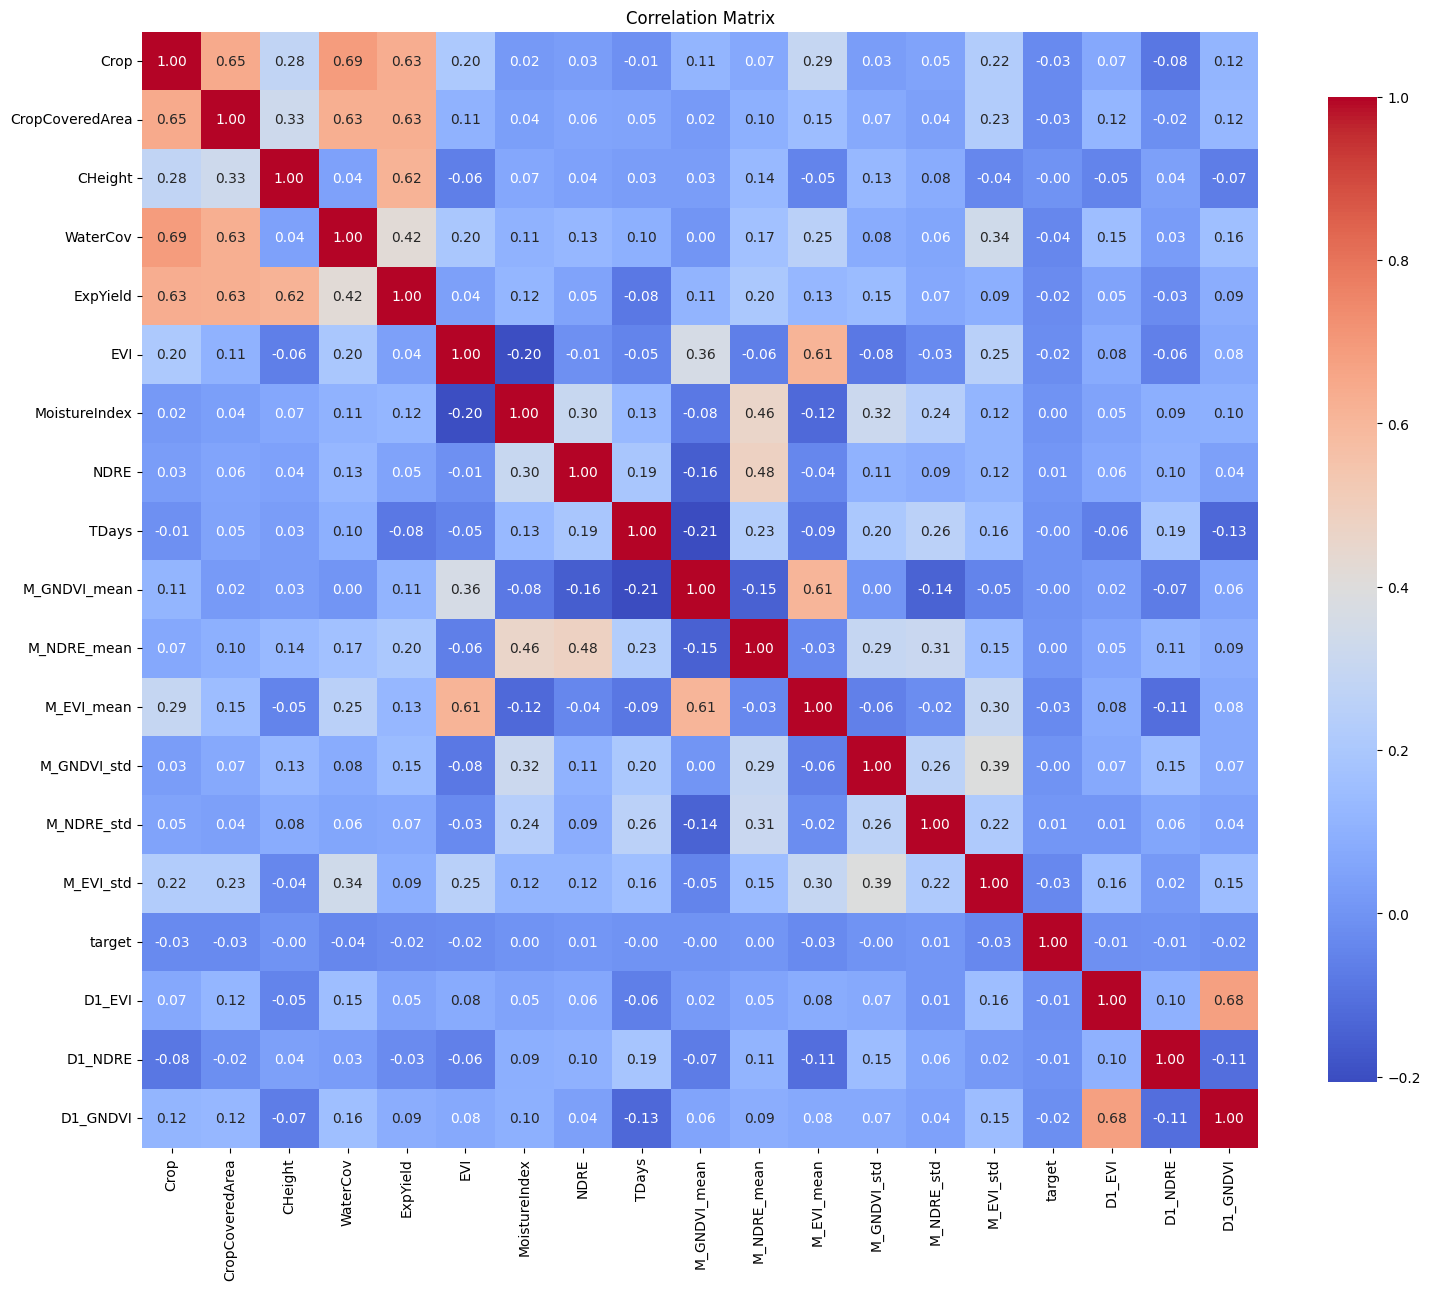

In [797]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train' is your DataFrame
correlation_matrix = train_df.corr()

plt.figure(figsize=(18, 16))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()

### Sampling Techniques 

In [1181]:
# Separate features and target variable in the train set
scaler = StandardScaler()
X = train_df.drop(columns=['target'])
X_scaled = scaler.fit_transform(X)
y = train_df['target'].astype(int)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, 
                                                      stratify=y, random_state=42)


X_train.shape, X_valid.shape

((6310, 18), (1578, 18))

In [902]:
# Define SMOTE (Oversampling) and Random Undersampling
# Set the sampling strategy as a dictionary for multi-class
smote = SMOTE(sampling_strategy={1: 400, 2: 500, 3: 500}, random_state=42)  # Adjust class-specific oversampling rates
undersample = RandomUnderSampler(sampling_strategy={1: 400, 2: 400, 3: 400}, random_state=42)  # Adjust class-specific undersampling rates

# Create a pipeline combining SMOTE and undersampling
hybrid_pipeline = Pipeline([
    ('smote', smote),
    ('under', undersample)
])

# Apply hybrid sampling
X_train_resampled, y_train_resampled = hybrid_pipeline.fit_resample(X_train, y_train)

In [915]:
from imblearn.ensemble import RUSBoostClassifier

# RUSBoost model with random undersampling
rusboost = RUSBoostClassifier(estimator=DecisionTreeClassifier(max_depth=10),
                              n_estimators=50, random_state=42)
rusboost.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_rus = rusboost.predict(X_valid_scaled)
print("RUSBoost Classification Report:\n", classification_report(y_valid, y_pred_rus))

RUSBoost Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1301
           1       0.16      0.09      0.12        95
           2       0.11      0.07      0.09        97
           3       0.04      0.01      0.02        85

    accuracy                           0.76      1578
   macro avg       0.28      0.27      0.27      1578
weighted avg       0.70      0.76      0.73      1578



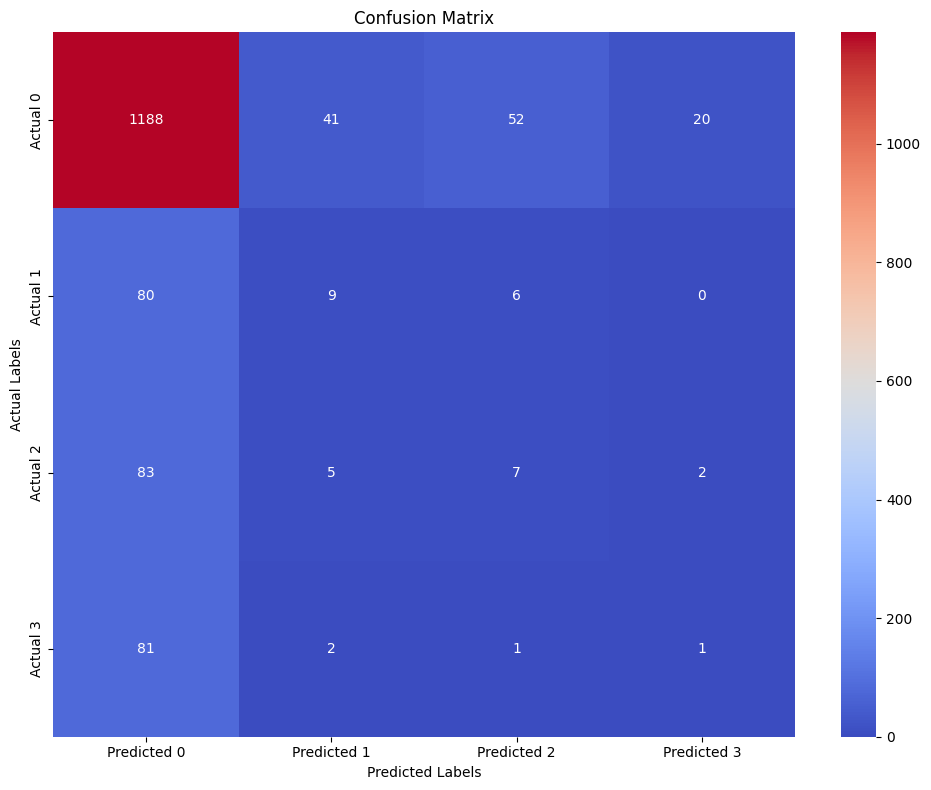

In [917]:
plot_confusion_matrix(y_valid, y_pred_rus)

### LGBM

In [1183]:
best_params = {'learning_rate': 0.09982325130958065,
 'num_leaves': 24,
 'max_depth': 21,
 'min_child_samples': 22,
 'subsample': 0.7496598722291121,
 'colsample_bytree': 0.5196832996117371,
 'reg_alpha': 0.07292322902793114,
 'reg_lambda': 0.05241872013079379}

In [1185]:
# Define LGBM model
lgbm_base = LGBMClassifier(
    objective='multiclass',
    class_weight='balanced',
    **best_params,
    random_state=42,)
lgbm_base.fit(X_train_reset, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4721
[LightGBM] [Info] Number of data points in the train set: 6310, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


LGBMClassifier(class_weight='balanced', colsample_bytree=0.5196832996117371,
               learning_rate=0.09982325130958065, max_depth=21,
               min_child_samples=22, num_leaves=24, objective='multiclass',
               random_state=42, reg_alpha=0.07292322902793114,
               reg_lambda=0.05241872013079379, subsample=0.7496598722291121)

In [1187]:
# Predict on the validation set
y_pred = lgbm_base.predict(X_valid_reset)

# Generate classification report and weighted F1 score
classification_rep = classification_report(y_valid, y_pred, target_names=list(category_mapper.keys()))
f1 = f1_score(y_valid, y_pred, average='weighted')

# Print model evaluation metrics
print("Classification Report:\n", classification_rep)
print("\nWeighted F1 Score:", f1)

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.83      0.82      0.83      1301
    Diseased       0.07      0.07      0.07        95
       Pests       0.05      0.05      0.05        97
    Stressed       0.05      0.05      0.05        85

    accuracy                           0.69      1578
   macro avg       0.25      0.25      0.25      1578
weighted avg       0.69      0.69      0.69      1578


Weighted F1 Score: 0.690849944124062


In [1189]:
category_mapper

{'Healthy': 0, 'Diseased': 1, 'Pests': 2, 'Stressed': 3}

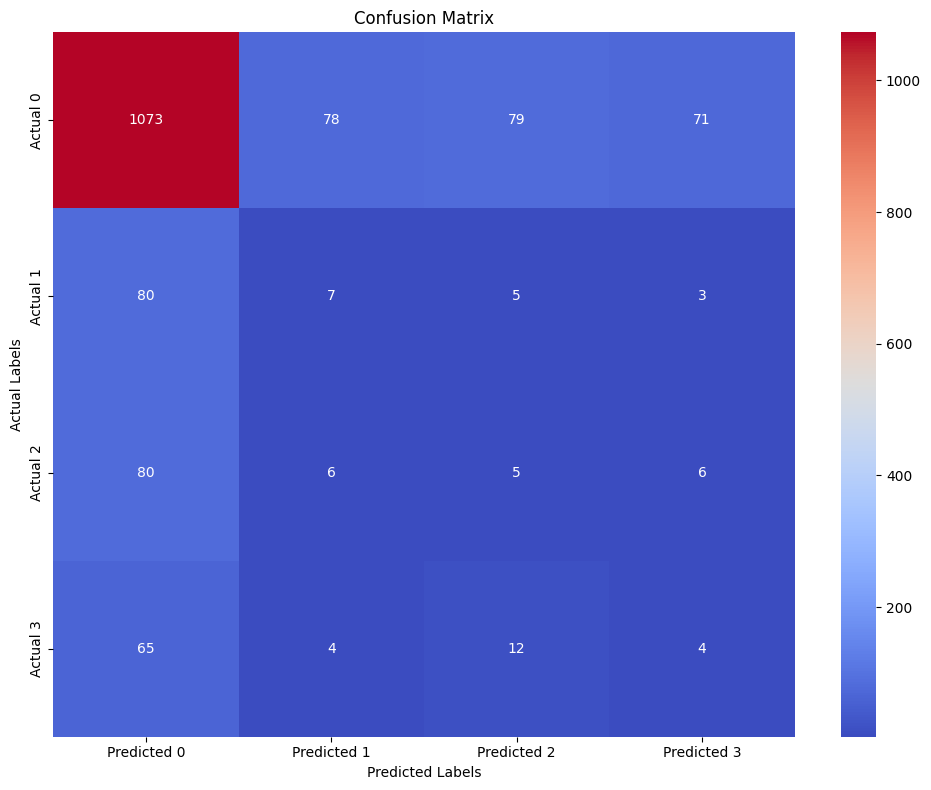

In [1191]:
plot_confusion_matrix(y_valid, y_pred)

### Ensemble Machine Learning 

In [943]:
from sklearn.ensemble import StackingClassifier, VotingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression

In [945]:
lgbm_base_res = LGBMClassifier(
    objective='multiclass',
    class_weight='balanced',
    #**best_params,
    random_state=42,)
lgbm_base_res.fit(X_train_resampled, y_train_resampled)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3704
[LightGBM] [Info] Number of data points in the train set: 6405, number of used features: 18
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


LGBMClassifier(class_weight='balanced', objective='multiclass', random_state=42)

In [947]:
# Predict on the validation set
y_pred_res = lgbm_base_res.predict(X_valid)

# Generate classification report and weighted F1 score
classification_rep = classification_report(y_valid, y_pred_res, target_names=list(category_mapper.keys()))
f1 = f1_score(y_valid, y_pred_scaled, average='weighted')

# Print model evaluation metrics
print("Classification Report:\n", classification_rep)
print("\nWeighted F1 Score:", f1)

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.82      0.84      0.83      1301
    Diseased       0.07      0.06      0.07        95
       Pests       0.04      0.03      0.03        97
    Stressed       0.06      0.06      0.06        85

    accuracy                           0.70      1578
   macro avg       0.25      0.25      0.25      1578
weighted avg       0.69      0.70      0.69      1578


Weighted F1 Score: 0.6932054751308574


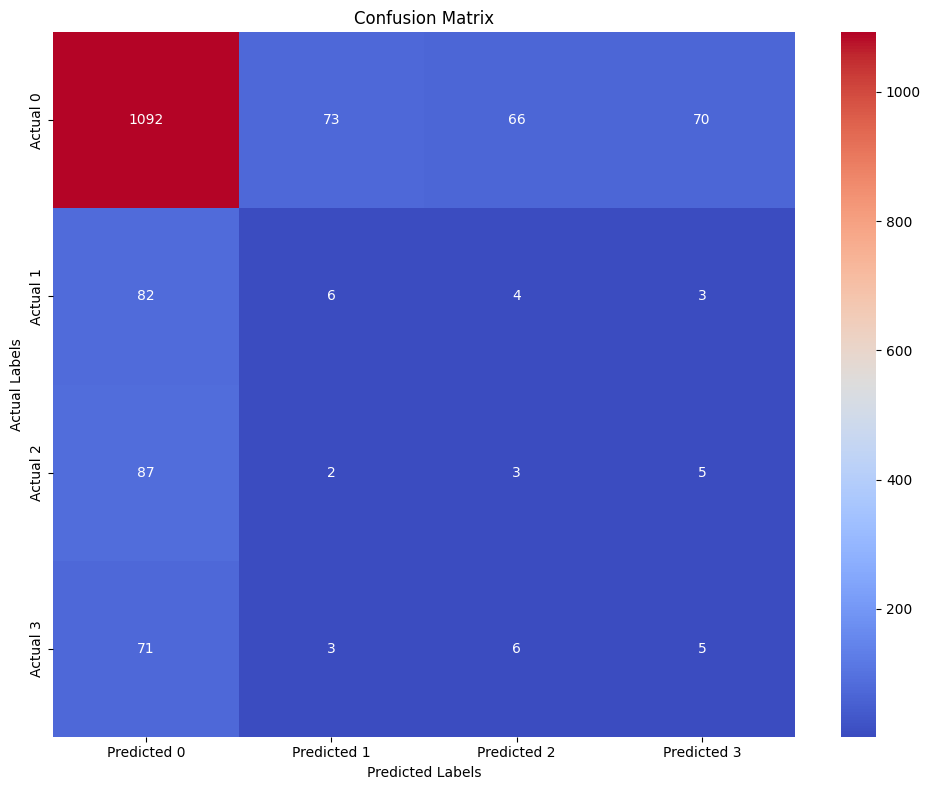

In [949]:
plot_confusion_matrix(y_valid, y_pred_res)

In [957]:
# Voting Classifier (Weighted Voting)
voting_model = VotingClassifier(estimators=[
    ('lgbm_resample', lgbm_base_res),
    ('lgbm_no_scale', lgbm_base),
    ('rusboost', rusboost)
], voting='soft', weights=[1, 2, 1])  # Adjust weights based on model performance


In [959]:
# Train Stacked Model
voting_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3701
[LightGBM] [Info] Number of data points in the train set: 6310, number of used features: 18
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3701
[LightGBM] [Info] Number of data points in the train set: 6310, number of used features: 18
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1

VotingClassifier(estimators=[('lgbm_resample',
                              LGBMClassifier(class_weight='balanced',
                                             objective='multiclass',
                                             random_state=42)),
                             ('lgbm_no_scale',
                              LGBMClassifier(class_weight='balanced',
                                             learning_rate=0.09, num_leaves=40,
                                             objective='multiclass',
                                             random_state=42)),
                             ('rusboost',
                              RUSBoostClassifier(estimator=DecisionTreeClassifier(max_depth=10),
                                                 random_state=42))],
                 voting='soft', weights=[1, 2, 1])

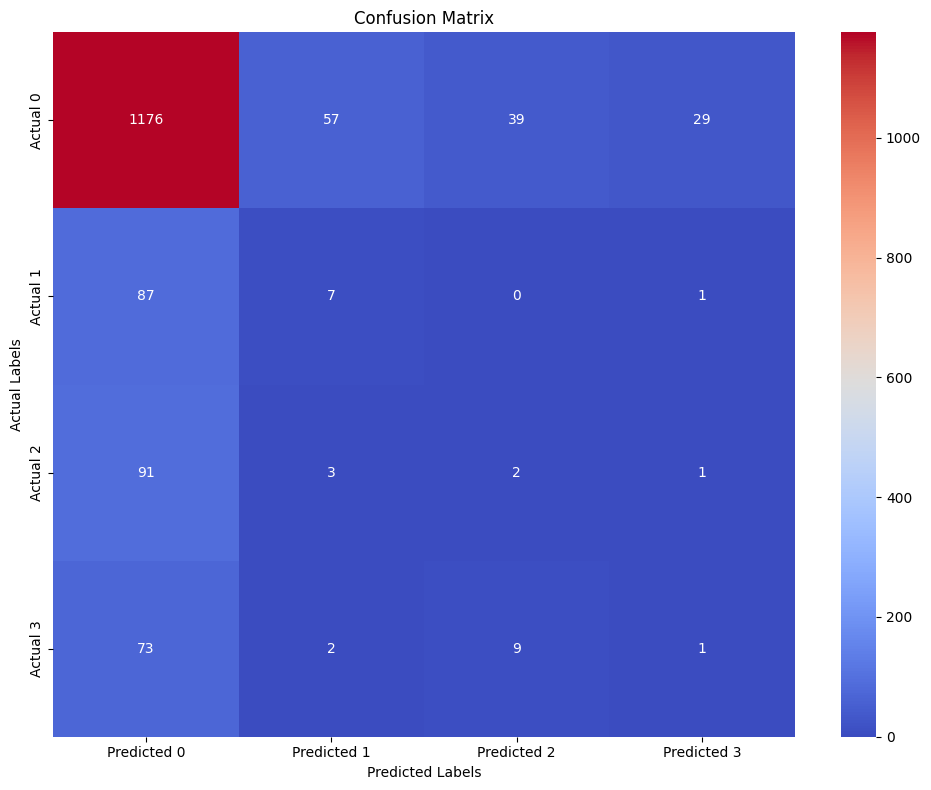

In [961]:
y_pred_vote = voting_model.predict(X_valid)
plot_confusion_matrix(y_valid, y_pred_vote)

In [963]:
# Generate classification report and weighted F1 score
classification_rep = classification_report(y_valid, y_pred_vote, target_names=list(category_mapper.keys()))
f1 = f1_score(y_valid, y_pred_vote, average='weighted')

# Print model evaluation metrics
print("Classification Report:\n", classification_rep)
print("\nWeighted F1 Score:", f1)

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.82      0.90      0.86      1301
    Diseased       0.10      0.07      0.09        95
       Pests       0.04      0.02      0.03        97
    Stressed       0.03      0.01      0.02        85

    accuracy                           0.75      1578
   macro avg       0.25      0.25      0.25      1578
weighted avg       0.69      0.75      0.72      1578


Weighted F1 Score: 0.718558610767011


In [976]:
bagging_model = BaggingClassifier(estimator=lgbm_base, n_estimators=50, random_state=42)
# Train Bagging Model
bagging_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3701
[LightGBM] [Info] Number of data points in the train set: 6310, number of used features: 18
[LightGBM] [Info] Start training from score -1.387958
[LightGBM] [Info] Start training from score -1.333261
[LightGBM] [Info] Start training from score -1.382048
[LightGBM] [Info] Start training from score -1.445044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3701
[LightGBM] [Info] Number of data points in the train set: 6310, number of used features: 18
[LightGBM] [Info] Start training from score -1.382599
[LightGBM] [Info] Start training from score -1.449361
[LightGBM] [Info] Start training from score -1.399527
[LightGBM] [Info] Start training from score -1

BaggingClassifier(estimator=LGBMClassifier(class_weight='balanced',
                                           learning_rate=0.09, num_leaves=40,
                                           objective='multiclass',
                                           random_state=42),
                  n_estimators=50, random_state=42)

In [978]:
# Predict on the validation set
y_pred_bagg = bagging_model.predict(X_valid)

# Generate classification report and weighted F1 score
classification_rep = classification_report(y_valid, y_pred_bagg, target_names=list(category_mapper.keys()))
f1 = f1_score(y_valid, y_pred_bagg, average='weighted')

# Print model evaluation metrics
print("Classification Report:\n", classification_rep)
print("\nWeighted F1 Score:", f1)

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.83      0.99      0.90      1301
    Diseased       0.30      0.03      0.06        95
       Pests       0.00      0.00      0.00        97
    Stressed       0.00      0.00      0.00        85

    accuracy                           0.82      1578
   macro avg       0.28      0.26      0.24      1578
weighted avg       0.70      0.82      0.75      1578


Weighted F1 Score: 0.7468352200800455


/opt/anaconda3/envs/geoai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/geoai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/geoai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Random Forest

In [2991]:
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=500, 
                                     max_depth=40,
                                     min_samples_split=8,
                                     random_state=42,
                                    )
brf.fit(X_train, y_train)

BalancedRandomForestClassifier(max_depth=40, min_samples_split=8,
                               n_estimators=500, random_state=42)

In [2993]:
# Predict on the validation set
y_pred = brf.predict(X_valid)

# Generate classification report and weighted F1 score
classification_rep = classification_report(y_valid, y_pred, target_names=list(category_mapper.keys()))
f1 = f1_score(y_valid, y_pred, average='weighted')

# Print model evaluation metrics
print("Classification Report:\n", classification_rep)
print("\nWeighted F1 Score:", f1)

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.82      0.62      0.71      1278
    Diseased       0.10      0.20      0.14        93
       Pests       0.05      0.12      0.07        95
    Stressed       0.07      0.14      0.09        83

    accuracy                           0.54      1549
   macro avg       0.26      0.27      0.25      1549
weighted avg       0.69      0.54      0.60      1549


Weighted F1 Score: 0.6020026741770416


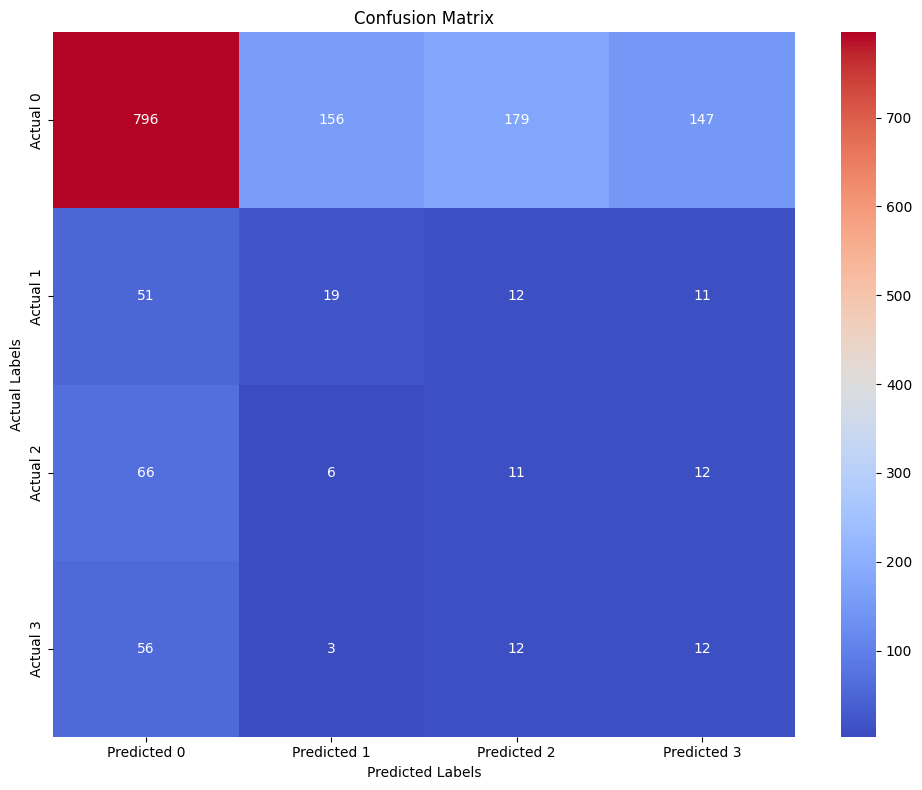

In [2995]:
plot_confusion_matrix(y_valid, y_pred)

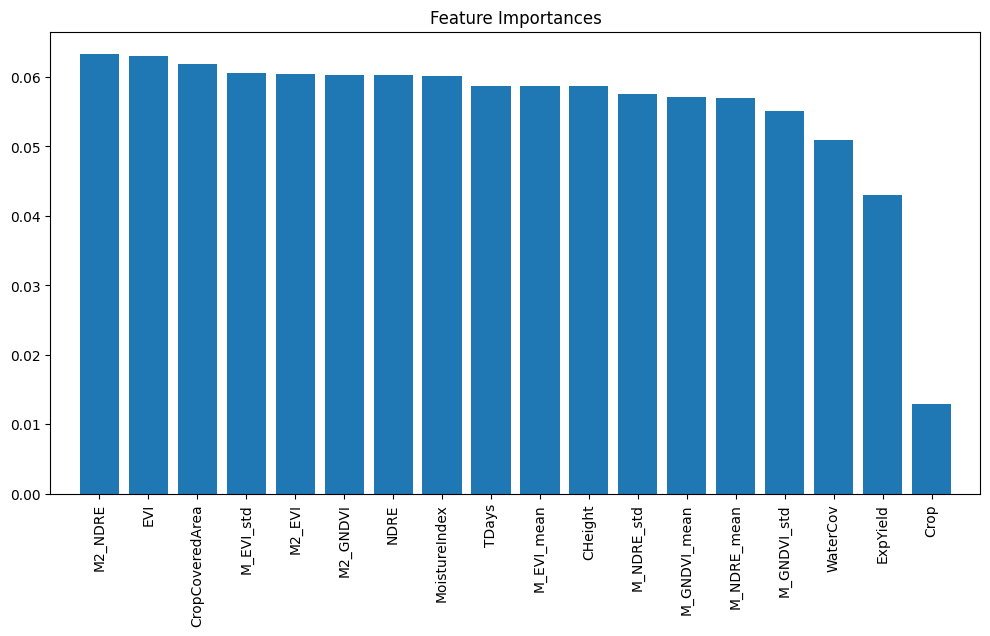

In [2997]:
# Get feature importances
importances = brf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

### Model Prob Reset

In [1036]:
probs_train = lgbm_base_scaled.predict_proba(X_train_scaled)
probs_valid = lgbm_base_scaled.predict_proba(X_valid_scaled)

probs.shape, probs_valid.shape

((6310, 4), (1578, 4))

In [1038]:
probs_df_train = pd.DataFrame(probs_train, columns=[f'prob_class_{i}' for i in range(probs.shape[1])])
probs_df_valid = pd.DataFrame(probs_valid, columns=[f'prob_class_{i}' for i in range(probs.shape[1])])

probs_df_train.head()

prob_class_0  prob_class_1  prob_class_2  prob_class_3
0      0.918140      0.075916      0.004942      0.001002
1      0.759385      0.221577      0.016067      0.002970
2      0.936602      0.058363      0.003127      0.001907
3      0.937789      0.051558      0.003240      0.007414
4      0.978901      0.008557      0.011277      0.001266

In [1042]:
X_train.shape, probs_df_train.shape

((6310, 18), (6310, 4))

In [1050]:
X_train_reset = pd.concat([X_train.reset_index(drop=True), probs_df_train], axis=1)
X_valid_reset = pd.concat([X_valid.reset_index(drop=True), probs_df_valid], axis=1)
X_train_reset.shape, X_valid_reset.shape

((6310, 22), (1578, 22))

## Model Tuning

In [1117]:
import optuna
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from optuna.integration import LightGBMTunerCV
from sklearn.metrics import f1_score, classification_report
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

def objective(trial):
    params = {
        'objective': 'multiclass',
        'num_class': len(np.unique(y_train)),
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'class_weight': 'balanced',
        'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 8, 24),
        'max_depth': trial.suggest_int('max_depth', -1, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, valid_idx in cv.split(X_train_reset, y_train):
        X_cv_train, X_cv_valid = X_train_reset.iloc[train_idx], X_train_reset.iloc[valid_idx]
        y_cv_train, y_cv_valid = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        
        model = LGBMClassifier(**params)
        model.fit(X_cv_train, y_cv_train, eval_set=[(X_cv_valid, y_cv_valid)], 
                 callbacks=[early_stopping(stopping_rounds=20), log_evaluation(10)], 
                  )
        
        y_pred = model.predict(X_cv_valid)
        scores.append(f1_score(y_cv_valid, y_pred, average='weighted'))
    
    return np.mean(scores)

In [1119]:
# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2025-02-04 17:42:57,353] A new study created in memory with name: no-name-d5873f1e-e928-4a55-a65f-fe10931d5bf7
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.31927
[20]	valid_0's multi_logloss: 1.26675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's multi_logloss: 1.22363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	valid_0's multi_logloss: 1.18486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-02-04 17:43:01,934] Trial 0 finished with value: 0.6589319224523721 and parameters: {'learning_rate': 0.07379952499245641, 'num_leaves': 19, 'max_depth': 7, 'min_child_samples': 13, 'subsample': 0.5644422635998549, 'colsample_bytree': 0.6638841570965504, 'reg_alpha': 0.017959311032894044, 'reg_lambda': 0.09122549974970312}. Best is trial 0 with value: 0.6589319224523721.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's multi_logloss: 1.07436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	valid_0's multi_logloss: 1.04887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's multi_logloss: 1.02212
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.02212


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.37076
[20]	valid_0's multi_logloss: 1.35905
[30]	valid_0's multi_logloss: 1.34961
[40]	valid_0's multi_logloss: 1.34096
[50]	valid_0's multi_logloss: 1.33379
[60]	valid_0's multi_logloss: 1.32545
[70]	valid_0's multi_logloss: 1.31813
[80]	valid_0's multi_logloss: 1.31121
[90]	valid_0's multi_logloss: 1.30403
[100]	valid_0's multi_logloss: 1.29608
Did not meet early stopping. Best iteration is:
[100]	

[I 2025-02-04 17:43:04,416] Trial 1 finished with value: 0.44009582252811336 and parameters: {'learning_rate': 0.032221520862664, 'num_leaves': 9, 'max_depth': 15, 'min_child_samples': 5, 'subsample': 0.5884840353998043, 'colsample_bytree': 0.9134699441740274, 'reg_alpha': 0.7329350632410939, 'reg_lambda': 7.2100672430709}. Best is trial 0 with value: 0.6589319224523721.
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.34497
[20]	valid_0's multi_logloss: 1.31133
[30]	valid_0's multi_logloss: 1.28636
[40]	valid_0's multi_logloss: 1.25881
[50]	valid_0's multi_logloss: 1.23217
[60]	valid_0's multi_logloss: 1.20568
[70]	valid_0's multi_logloss: 1.18105
[80]	valid_0's multi_logloss: 1.15882
[90]	valid_0's multi_logloss: 1.1364
[100]	valid_0's multi_logloss: 1.11521
Did not meet early stopping. Best iteration is:
[100]	v

[I 2025-02-04 17:43:08,206] Trial 2 finished with value: 0.5941818902284193 and parameters: {'learning_rate': 0.057216506229078076, 'num_leaves': 15, 'max_depth': 21, 'min_child_samples': 29, 'subsample': 0.6222109954137344, 'colsample_bytree': 0.6996746722648775, 'reg_alpha': 0.6893850234435994, 'reg_lambda': 0.490746839539966}. Best is trial 0 with value: 0.6589319224523721.


[80]	valid_0's multi_logloss: 1.17291
[90]	valid_0's multi_logloss: 1.15209
[100]	valid_0's multi_logloss: 1.13177
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.13177
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.36747
[20]	valid_0's multi_logloss: 1.3511
[30]	valid_0's multi_logloss: 1.337
[40]	valid_0's multi_logloss: 1.32264
[50]	valid_0's multi_logloss: 1.31056
[60]	valid_0's multi_logloss: 1.30057
[70]	valid_0's multi_logloss: 1.29041
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's multi_logloss: 1.27995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	valid_0's multi_logloss: 1.26991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's multi_logloss: 1.26069
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.26069
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead

[I 2025-02-04 17:43:11,400] Trial 3 finished with value: 0.4752639060035925 and parameters: {'learning_rate': 0.027860164353777882, 'num_leaves': 13, 'max_depth': 6, 'min_child_samples': 38, 'subsample': 0.9523338163818158, 'colsample_bytree': 0.6531350945491117, 'reg_alpha': 1.2191202508352654, 'reg_lambda': 0.9926303202307613}. Best is trial 0 with value: 0.6589319224523721.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	valid_0's multi_logloss: 1.29041
[100]	valid_0's multi_logloss: 1.28172
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.28172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.35294


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.33047
[30]	valid_0's multi_logloss: 1.30748
[40]	valid_0's multi_logloss: 1.28909
[50]	valid_0's multi_logloss: 1.26701
[60]	valid_0's multi_logloss: 1.24696
[70]	valid_0's multi_logloss: 1.22826
[80]	valid_0's multi_logloss: 1.21128
[90]	valid_0's multi_logloss: 1.1944
[100]	valid_0's multi_logloss: 1.17774
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.17774
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	v

[I 2025-02-04 17:43:14,949] Trial 4 finished with value: 0.5469950752307566 and parameters: {'learning_rate': 0.06564384920036898, 'num_leaves': 13, 'max_depth': 27, 'min_child_samples': 10, 'subsample': 0.8474069525736033, 'colsample_bytree': 0.7997098061974072, 'reg_alpha': 1.453315573621937, 'reg_lambda': 8.48500813732076}. Best is trial 0 with value: 0.6589319224523721.


[80]	valid_0's multi_logloss: 1.22048
[90]	valid_0's multi_logloss: 1.20158
[100]	valid_0's multi_logloss: 1.18499
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.18499
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.32652
[20]	valid_0's multi_logloss: 1.26969
[30]	valid_0's multi_logloss: 1.22305
[40]	valid_0's multi_logloss: 1.17874
[50]	valid_0's multi_logloss: 1.1452
[60]	valid_0's multi_logloss: 1.10878
[70]	valid_0's multi_logloss: 1.0764
[80]	valid_0's multi_logloss: 1.0457
[90]	valid_0's multi_logloss: 1.01946
[100]	valid_0's multi_logloss: 0.997113
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.997113
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Star

[I 2025-02-04 17:43:19,420] Trial 5 finished with value: 0.6515333484034884 and parameters: {'learning_rate': 0.09279483756729183, 'num_leaves': 18, 'max_depth': 7, 'min_child_samples': 10, 'subsample': 0.705784202137071, 'colsample_bytree': 0.8888807252010684, 'reg_alpha': 4.244147169300416, 'reg_lambda': 0.15779966847466523}. Best is trial 0 with value: 0.6589319224523721.


[80]	valid_0's multi_logloss: 1.07016
[90]	valid_0's multi_logloss: 1.04249
[100]	valid_0's multi_logloss: 1.01855
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.01855
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.32581
[20]	valid_0's multi_logloss: 1.27926
[30]	valid_0's multi_logloss: 1.23826
[40]	valid_0's multi_logloss: 1.19929
[50]	valid_0's multi_logloss: 1.15589
[60]	valid_0's multi_logloss: 1.12143
[70]	valid_0's multi_logloss: 1.08808
[80]	valid_0's multi_logloss: 1.05652
[90]	valid_0's multi_logloss: 1.03078
[100]	valid_0's multi_logloss: 1.00473
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.00473
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation sc

[I 2025-02-04 17:43:24,470] Trial 6 finished with value: 0.6535627261432566 and parameters: {'learning_rate': 0.06110377499816265, 'num_leaves': 21, 'max_depth': 18, 'min_child_samples': 48, 'subsample': 0.9928437417866582, 'colsample_bytree': 0.834466167665766, 'reg_alpha': 0.018881504949917968, 'reg_lambda': 0.22379853261161328}. Best is trial 0 with value: 0.6589319224523721.


[90]	valid_0's multi_logloss: 1.05783
[100]	valid_0's multi_logloss: 1.0323
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.0323
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.30022
[20]	valid_0's multi_logloss: 1.23481
[30]	valid_0's multi_logloss: 1.17628
[40]	valid_0's multi_logloss: 1.12142
[50]	valid_0's multi_logloss: 1.07596
[60]	valid_0's multi_logloss: 1.02998
[70]	valid_0's multi_logloss: 0.991903
[80]	valid_0's multi_logloss: 0.959065
[90]	valid_0's multi_logloss: 0.932236
[100]	valid_0's multi_logloss: 0.90304
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.90304
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation

[I 2025-02-04 17:43:29,898] Trial 7 finished with value: 0.6956462873286409 and parameters: {'learning_rate': 0.08910080430911338, 'num_leaves': 22, 'max_depth': 17, 'min_child_samples': 35, 'subsample': 0.9012153846151945, 'colsample_bytree': 0.5359873813383679, 'reg_alpha': 0.054920459564496864, 'reg_lambda': 0.17097967380374873}. Best is trial 7 with value: 0.6956462873286409.


[90]	valid_0's multi_logloss: 0.944456
[100]	valid_0's multi_logloss: 0.917202
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.917202
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.33213
[20]	valid_0's multi_logloss: 1.28208
[30]	valid_0's multi_logloss: 1.23327
[40]	valid_0's multi_logloss: 1.19271
[50]	valid_0's multi_logloss: 1.15139
[60]	valid_0's multi_logloss: 1.11841
[70]	valid_0's multi_logloss: 1.08701
[80]	valid_0's multi_logloss: 1.05681
[90]	valid_0's multi_logloss: 1.03035
[100]	valid_0's multi_logloss: 1.00692
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.00692
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation sc

[I 2025-02-04 17:43:34,881] Trial 8 finished with value: 0.6478956872804926 and parameters: {'learning_rate': 0.08771531095694281, 'num_leaves': 19, 'max_depth': 19, 'min_child_samples': 15, 'subsample': 0.5031657110381808, 'colsample_bytree': 0.8955575604258799, 'reg_alpha': 0.016709875686193598, 'reg_lambda': 7.330102867971567}. Best is trial 7 with value: 0.6956462873286409.
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.34633
[20]	valid_0's multi_logloss: 1.31341
[30]	valid_0's multi_logloss: 1.28549
[40]	valid_0's multi_logloss: 1.25776
[50]	valid_0's multi_logloss: 1.23423
[60]	valid_0's multi_logloss: 1.20895
[70]	valid_0's multi_logloss: 1.18269
[80]	valid_0's multi_logloss: 1.15795
[90]	valid_0's multi_logloss: 1.13393
[100]	valid_0's multi_logloss: 1.11249
Did not meet early stopping. Best iteration is:
[100]	

[I 2025-02-04 17:43:40,100] Trial 9 finished with value: 0.6021166409488871 and parameters: {'learning_rate': 0.039788433462928735, 'num_leaves': 21, 'max_depth': 18, 'min_child_samples': 39, 'subsample': 0.8662092677449984, 'colsample_bytree': 0.5867863652086115, 'reg_alpha': 0.44595014614611667, 'reg_lambda': 0.7113590145657607}. Best is trial 7 with value: 0.6956462873286409.


[100]	valid_0's multi_logloss: 1.13457
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.13457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.29889


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.23307
[30]	valid_0's multi_logloss: 1.17278
[40]	valid_0's multi_logloss: 1.12265
[50]	valid_0's multi_logloss: 1.07377
[60]	valid_0's multi_logloss: 1.0291
[70]	valid_0's multi_logloss: 0.99467
[80]	valid_0's multi_logloss: 0.961254
[90]	valid_0's multi_logloss: 0.932305
[100]	valid_0's multi_logloss: 0.904793
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.904793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[1

[I 2025-02-04 17:43:46,110] Trial 10 finished with value: 0.6989943802590134 and parameters: {'learning_rate': 0.08093019883093455, 'num_leaves': 24, 'max_depth': 42, 'min_child_samples': 24, 'subsample': 0.7896878212608601, 'colsample_bytree': 0.5106862253572962, 'reg_alpha': 0.07667732941762018, 'reg_lambda': 0.01293442053361502}. Best is trial 10 with value: 0.6989943802590134.


[100]	valid_0's multi_logloss: 0.913878
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.913878
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.29619


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.2218
[30]	valid_0's multi_logloss: 1.16161
[40]	valid_0's multi_logloss: 1.10707
[50]	valid_0's multi_logloss: 1.05474
[60]	valid_0's multi_logloss: 1.01168
[70]	valid_0's multi_logloss: 0.97255
[80]	valid_0's multi_logloss: 0.935537
[90]	valid_0's multi_logloss: 0.905911
[100]	valid_0's multi_logloss: 0.876056
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.876056
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[1

[I 2025-02-04 17:43:52,020] Trial 11 finished with value: 0.7058614367634577 and parameters: {'learning_rate': 0.08493857564405255, 'num_leaves': 24, 'max_depth': 42, 'min_child_samples': 24, 'subsample': 0.8064503161141188, 'colsample_bytree': 0.5109434406959469, 'reg_alpha': 0.0875553876265094, 'reg_lambda': 0.018975060239584462}. Best is trial 11 with value: 0.7058614367634577.


[100]	valid_0's multi_logloss: 0.904468
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.904468
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.29755


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.23149
[30]	valid_0's multi_logloss: 1.17782
[40]	valid_0's multi_logloss: 1.12613
[50]	valid_0's multi_logloss: 1.08019
[60]	valid_0's multi_logloss: 1.03445
[70]	valid_0's multi_logloss: 0.996736
[80]	valid_0's multi_logloss: 0.959485
[90]	valid_0's multi_logloss: 0.928724
[100]	valid_0's multi_logloss: 0.899007
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.899007
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


[I 2025-02-04 17:43:58,018] Trial 12 finished with value: 0.6998271974942694 and parameters: {'learning_rate': 0.08047742698037406, 'num_leaves': 24, 'max_depth': 44, 'min_child_samples': 22, 'subsample': 0.763005562360133, 'colsample_bytree': 0.5383395768772441, 'reg_alpha': 0.11515833808959584, 'reg_lambda': 0.013484147190728333}. Best is trial 11 with value: 0.7058614367634577.


[100]	valid_0's multi_logloss: 0.915265
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.915265
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28133


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.20565
[30]	valid_0's multi_logloss: 1.13853
[40]	valid_0's multi_logloss: 1.07622
[50]	valid_0's multi_logloss: 1.01946
[60]	valid_0's multi_logloss: 0.974368
[70]	valid_0's multi_logloss: 0.93508
[80]	valid_0's multi_logloss: 0.898893
[90]	valid_0's multi_logloss: 0.868645
[100]	valid_0's multi_logloss: 0.842001
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.842001
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


[I 2025-02-04 17:44:04,046] Trial 13 finished with value: 0.7145846961585726 and parameters: {'learning_rate': 0.09880666855691535, 'num_leaves': 24, 'max_depth': 50, 'min_child_samples': 22, 'subsample': 0.7072188578772074, 'colsample_bytree': 0.5896542706420773, 'reg_alpha': 0.12082972590468712, 'reg_lambda': 0.010873272988648605}. Best is trial 13 with value: 0.7145846961585726.


[100]	valid_0's multi_logloss: 0.86712
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.86712
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28025


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.20247
[30]	valid_0's multi_logloss: 1.1322
[40]	valid_0's multi_logloss: 1.0662
[50]	valid_0's multi_logloss: 1.01536
[60]	valid_0's multi_logloss: 0.969747
[70]	valid_0's multi_logloss: 0.930184
[80]	valid_0's multi_logloss: 0.892354
[90]	valid_0's multi_logloss: 0.867581
[100]	valid_0's multi_logloss: 0.841043
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.841043
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[

[I 2025-02-04 17:44:10,077] Trial 14 finished with value: 0.7157040851042392 and parameters: {'learning_rate': 0.09925297305800404, 'num_leaves': 24, 'max_depth': 50, 'min_child_samples': 20, 'subsample': 0.6895836430170683, 'colsample_bytree': 0.6050839129920275, 'reg_alpha': 0.23178908252855976, 'reg_lambda': 0.04123505392321266}. Best is trial 14 with value: 0.7157040851042392.


[100]	valid_0's multi_logloss: 0.871016
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.871016
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.33991
[20]	valid_0's multi_logloss: 1.31102
[30]	valid_0's multi_logloss: 1.28307


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[40]	valid_0's multi_logloss: 1.25754
[50]	valid_0's multi_logloss: 1.23246
[60]	valid_0's multi_logloss: 1.21265
[70]	valid_0's multi_logloss: 1.19383
[80]	valid_0's multi_logloss: 1.17334
[90]	valid_0's multi_logloss: 1.15545
[100]	valid_0's multi_logloss: 1.13931
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.13931
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.34946
[20]	valid_0's multi_logloss: 1.32132
[30]	

[I 2025-02-04 17:44:12,501] Trial 15 finished with value: 0.5704212706401254 and parameters: {'learning_rate': 0.09762361030688586, 'num_leaves': 9, 'max_depth': 49, 'min_child_samples': 19, 'subsample': 0.6887989885051039, 'colsample_bytree': 0.60511338733423, 'reg_alpha': 0.17759280024730767, 'reg_lambda': 0.04243107774041354}. Best is trial 14 with value: 0.7157040851042392.


[80]	valid_0's multi_logloss: 1.18926
[90]	valid_0's multi_logloss: 1.16875
[100]	valid_0's multi_logloss: 1.1501
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.1501
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.3071
[20]	valid_0's multi_logloss: 1.25344
[30]	valid_0's multi_logloss: 1.20395
[40]	valid_0's multi_logloss: 1.15723
[50]	valid_0's multi_logloss: 1.10887
[60]	valid_0's multi_logloss: 1.06719
[70]	valid_0's multi_logloss: 1.03516
[80]	valid_0's multi_logloss: 1.00771
[90]	valid_0's multi_logloss: 0.977794
[100]	valid_0's multi_logloss: 0.951756
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.951756
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation 

[I 2025-02-04 17:44:16,860] Trial 16 finished with value: 0.6757936607273246 and parameters: {'learning_rate': 0.09798904993694382, 'num_leaves': 17, 'max_depth': 32, 'min_child_samples': 30, 'subsample': 0.6777127487178226, 'colsample_bytree': 0.7554870376698427, 'reg_alpha': 0.2872287826152485, 'reg_lambda': 0.03404233250367025}. Best is trial 14 with value: 0.7157040851042392.


[90]	valid_0's multi_logloss: 0.989835
[100]	valid_0's multi_logloss: 0.967042
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.967042
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.32468
[20]	valid_0's multi_logloss: 1.27801
[30]	valid_0's multi_logloss: 1.23637
[40]	valid_0's multi_logloss: 1.19792
[50]	valid_0's multi_logloss: 1.16504
[60]	valid_0's multi_logloss: 1.13076
[70]	valid_0's multi_logloss: 1.10241
[80]	valid_0's multi_logloss: 1.07741
[90]	valid_0's multi_logloss: 1.04876
[100]	valid_0's multi_logloss: 1.02313
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.02313
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation sc

[I 2025-02-04 17:44:22,575] Trial 17 finished with value: 0.6473831385837515 and parameters: {'learning_rate': 0.051993788905475236, 'num_leaves': 22, 'max_depth': 35, 'min_child_samples': 19, 'subsample': 0.7093077148423559, 'colsample_bytree': 0.9912961565715285, 'reg_alpha': 0.037432352572575094, 'reg_lambda': 0.051969042148459196}. Best is trial 14 with value: 0.7157040851042392.


[90]	valid_0's multi_logloss: 1.06153
[100]	valid_0's multi_logloss: 1.03587
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.03587
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.33547
[20]	valid_0's multi_logloss: 1.29822
[30]	valid_0's multi_logloss: 1.26708
[40]	valid_0's multi_logloss: 1.23257
[50]	valid_0's multi_logloss: 1.1982
[60]	valid_0's multi_logloss: 1.16746
[70]	valid_0's multi_logloss: 1.14374
[80]	valid_0's multi_logloss: 1.11917
[90]	valid_0's multi_logloss: 1.09072
[100]	valid_0's multi_logloss: 1.0722
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.0722
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation score

[I 2025-02-04 17:44:27,730] Trial 18 finished with value: 0.6223555574095471 and parameters: {'learning_rate': 0.0718205385489478, 'num_leaves': 20, 'max_depth': 50, 'min_child_samples': 31, 'subsample': 0.6424895864825224, 'colsample_bytree': 0.5962139003946502, 'reg_alpha': 5.096695537642026, 'reg_lambda': 1.8957259262821315}. Best is trial 14 with value: 0.7157040851042392.


[100]	valid_0's multi_logloss: 1.08539
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.08539
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28945


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.21807
[30]	valid_0's multi_logloss: 1.15191
[40]	valid_0's multi_logloss: 1.09331
[50]	valid_0's multi_logloss: 1.04209
[60]	valid_0's multi_logloss: 1.00113
[70]	valid_0's multi_logloss: 0.959852
[80]	valid_0's multi_logloss: 0.928827
[90]	valid_0's multi_logloss: 0.896292
[100]	valid_0's multi_logloss: 0.871324
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.871324
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


[I 2025-02-04 17:44:33,434] Trial 19 finished with value: 0.7028528518675319 and parameters: {'learning_rate': 0.0987315544453922, 'num_leaves': 23, 'max_depth': 36, 'min_child_samples': 50, 'subsample': 0.742494517296984, 'colsample_bytree': 0.7248729651719565, 'reg_alpha': 0.22539392214062676, 'reg_lambda': 0.0300921436824463}. Best is trial 14 with value: 0.7157040851042392.


[100]	valid_0's multi_logloss: 0.887891
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.887891
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.35233
[20]	valid_0's multi_logloss: 1.32139


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[30]	valid_0's multi_logloss: 1.29975
[40]	valid_0's multi_logloss: 1.28003
[50]	valid_0's multi_logloss: 1.25791
[60]	valid_0's multi_logloss: 1.23719
[70]	valid_0's multi_logloss: 1.21737
[80]	valid_0's multi_logloss: 1.19752
[90]	valid_0's multi_logloss: 1.1784
[100]	valid_0's multi_logloss: 1.1604
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.1604
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.35225
[20]	val

[I 2025-02-04 17:44:37,437] Trial 20 finished with value: 0.5631377762663734 and parameters: {'learning_rate': 0.046753719443969124, 'num_leaves': 15, 'max_depth': 46, 'min_child_samples': 18, 'subsample': 0.530866976284887, 'colsample_bytree': 0.6485491457129323, 'reg_alpha': 2.656173713714359, 'reg_lambda': 0.08050410135773758}. Best is trial 14 with value: 0.7157040851042392.


[80]	valid_0's multi_logloss: 1.21597
[90]	valid_0's multi_logloss: 1.19898
[100]	valid_0's multi_logloss: 1.18108
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.18108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.29896
[20]	valid_0's multi_logloss: 1.23026
[30]	valid_0's multi_logloss: 1.16725
[40]	valid_0's multi_logloss: 1.11439
[50]	valid_0's multi_logloss: 1.06577
[60]	valid_0's multi_logloss: 1.02299
[70]	valid_0's multi_logloss: 0.980399
[80]	valid_0's multi_logloss: 0.948266
[90]	valid_0's multi_logloss: 0.916946
[100]	valid_0's multi_logloss: 0.887463
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.887463
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validati

[I 2025-02-04 17:44:43,422] Trial 21 finished with value: 0.703406969656841 and parameters: {'learning_rate': 0.0834803368404949, 'num_leaves': 24, 'max_depth': 41, 'min_child_samples': 24, 'subsample': 0.8119763962800934, 'colsample_bytree': 0.5677713016549728, 'reg_alpha': 0.1236078119031998, 'reg_lambda': 0.019824973655154236}. Best is trial 14 with value: 0.7157040851042392.


[90]	valid_0's multi_logloss: 0.927145
[100]	valid_0's multi_logloss: 0.902125
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.902125
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.29877
[20]	valid_0's multi_logloss: 1.22974
[30]	valid_0's multi_logloss: 1.17176
[40]	valid_0's multi_logloss: 1.12336
[50]	valid_0's multi_logloss: 1.07072
[60]	valid_0's multi_logloss: 1.02748
[70]	valid_0's multi_logloss: 0.989838
[80]	valid_0's multi_logloss: 0.955221
[90]	valid_0's multi_logloss: 0.926263
[100]	valid_0's multi_logloss: 0.900615
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.900615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validati

[I 2025-02-04 17:44:48,906] Trial 22 finished with value: 0.6997952192317921 and parameters: {'learning_rate': 0.09041228522944884, 'num_leaves': 22, 'max_depth': 38, 'min_child_samples': 25, 'subsample': 0.645291357009782, 'colsample_bytree': 0.5001508896398279, 'reg_alpha': 0.04044070137950439, 'reg_lambda': 0.011078553717278493}. Best is trial 14 with value: 0.7157040851042392.


[90]	valid_0's multi_logloss: 0.937927
[100]	valid_0's multi_logloss: 0.909921
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.909921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.30016
[20]	valid_0's multi_logloss: 1.23443
[30]	valid_0's multi_logloss: 1.17638
[40]	valid_0's multi_logloss: 1.12968
[50]	valid_0's multi_logloss: 1.07791
[60]	valid_0's multi_logloss: 1.03569
[70]	valid_0's multi_logloss: 0.999082
[80]	valid_0's multi_logloss: 0.964391
[90]	valid_0's multi_logloss: 0.93316
[100]	valid_0's multi_logloss: 0.907858
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.907858
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validatio

[I 2025-02-04 17:44:54,900] Trial 23 finished with value: 0.6981203188890364 and parameters: {'learning_rate': 0.07641006284079113, 'num_leaves': 24, 'max_depth': 47, 'min_child_samples': 27, 'subsample': 0.7453534756753356, 'colsample_bytree': 0.6229791802968588, 'reg_alpha': 0.0928436277758099, 'reg_lambda': 0.022684652658463533}. Best is trial 14 with value: 0.7157040851042392.


[90]	valid_0's multi_logloss: 0.948694
[100]	valid_0's multi_logloss: 0.924368
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.924368
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.29204
[20]	valid_0's multi_logloss: 1.22237
[30]	valid_0's multi_logloss: 1.16235
[40]	valid_0's multi_logloss: 1.10709
[50]	valid_0's multi_logloss: 1.0578
[60]	valid_0's multi_logloss: 1.01447
[70]	valid_0's multi_logloss: 0.974737
[80]	valid_0's multi_logloss: 0.939006
[90]	valid_0's multi_logloss: 0.908138
[100]	valid_0's multi_logloss: 0.882924
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.882924
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validatio

[I 2025-02-04 17:45:00,420] Trial 24 finished with value: 0.6987693996138808 and parameters: {'learning_rate': 0.09128859177772423, 'num_leaves': 22, 'max_depth': 29, 'min_child_samples': 21, 'subsample': 0.8215431011042684, 'colsample_bytree': 0.553872663852921, 'reg_alpha': 0.17646021230198575, 'reg_lambda': 0.06509793926760436}. Best is trial 14 with value: 0.7157040851042392.


[90]	valid_0's multi_logloss: 0.940505
[100]	valid_0's multi_logloss: 0.912493
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.912493
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.29122
[20]	valid_0's multi_logloss: 1.22201
[30]	valid_0's multi_logloss: 1.16717
[40]	valid_0's multi_logloss: 1.11073
[50]	valid_0's multi_logloss: 1.06236
[60]	valid_0's multi_logloss: 1.01721
[70]	valid_0's multi_logloss: 0.98027
[80]	valid_0's multi_logloss: 0.944806
[90]	valid_0's multi_logloss: 0.911264
[100]	valid_0's multi_logloss: 0.880873
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.880873
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validatio

[I 2025-02-04 17:45:05,567] Trial 25 finished with value: 0.6958206378773936 and parameters: {'learning_rate': 0.09889863879376584, 'num_leaves': 20, 'max_depth': 40, 'min_child_samples': 15, 'subsample': 0.7779580107784793, 'colsample_bytree': 0.6874727789051172, 'reg_alpha': 0.37536623201381436, 'reg_lambda': 0.019863049835158877}. Best is trial 14 with value: 0.7157040851042392.


[100]	valid_0's multi_logloss: 0.915968
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.915968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.31222
[20]	valid_0's multi_logloss: 1.25875
[30]	valid_0's multi_logloss: 1.21176
[40]	valid_0's multi_logloss: 1.16277
[50]	valid_0's multi_logloss: 1.11928
[60]	valid_0's multi_logloss: 1.08013
[70]	valid_0's multi_logloss: 1.04507
[80]	valid_0's multi_logloss: 1.01037
[90]	valid_0's multi_logloss: 0.980845
[100]	valid_0's multi_logloss: 0.951049
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.951049
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation

[I 2025-02-04 17:45:11,525] Trial 26 finished with value: 0.6843501538760188 and parameters: {'learning_rate': 0.06856464656386482, 'num_leaves': 23, 'max_depth': 50, 'min_child_samples': 34, 'subsample': 0.8818646502061142, 'colsample_bytree': 0.6271621738124246, 'reg_alpha': 0.03203010993753847, 'reg_lambda': 0.10409860242311131}. Best is trial 14 with value: 0.7157040851042392.


[90]	valid_0's multi_logloss: 0.997162
[100]	valid_0's multi_logloss: 0.969247
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.969247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.33697
[20]	valid_0's multi_logloss: 1.29249
[30]	valid_0's multi_logloss: 1.25086
[40]	valid_0's multi_logloss: 1.21342
[50]	valid_0's multi_logloss: 1.17814
[60]	valid_0's multi_logloss: 1.14926
[70]	valid_0's multi_logloss: 1.12027
[80]	valid_0's multi_logloss: 1.09645
[90]	valid_0's multi_logloss: 1.07695
[100]	valid_0's multi_logloss: 1.057
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.057
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores

[I 2025-02-04 17:45:17,437] Trial 27 finished with value: 0.6321279590328807 and parameters: {'learning_rate': 0.08496841139608484, 'num_leaves': 23, 'max_depth': 46, 'min_child_samples': 26, 'subsample': 0.7298041653107394, 'colsample_bytree': 0.5705382018630778, 'reg_alpha': 9.322228135239111, 'reg_lambda': 0.011168005680630973}. Best is trial 14 with value: 0.7157040851042392.


[90]	valid_0's multi_logloss: 1.07657
[100]	valid_0's multi_logloss: 1.05528
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.05528
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.33511
[20]	valid_0's multi_logloss: 1.29967
[30]	valid_0's multi_logloss: 1.26768
[40]	valid_0's multi_logloss: 1.23712
[50]	valid_0's multi_logloss: 1.20741
[60]	valid_0's multi_logloss: 1.17957
[70]	valid_0's multi_logloss: 1.15685
[80]	valid_0's multi_logloss: 1.12994
[90]	valid_0's multi_logloss: 1.10896
[100]	valid_0's multi_logloss: 1.08942
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.08942
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation sc

[I 2025-02-04 17:45:20,350] Trial 28 finished with value: 0.6048319176815953 and parameters: {'learning_rate': 0.09382555584390743, 'num_leaves': 11, 'max_depth': -1, 'min_child_samples': 16, 'subsample': 0.6630326541119416, 'colsample_bytree': 0.5248495401022204, 'reg_alpha': 0.49916094937084154, 'reg_lambda': 0.025803962068467187}. Best is trial 14 with value: 0.7157040851042392.


[90]	valid_0's multi_logloss: 1.12846
[100]	valid_0's multi_logloss: 1.10722
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.10722
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.36142


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.34157
[30]	valid_0's multi_logloss: 1.32252
[40]	valid_0's multi_logloss: 1.30564
[50]	valid_0's multi_logloss: 1.29016
[60]	valid_0's multi_logloss: 1.2759
[70]	valid_0's multi_logloss: 1.26344
[80]	valid_0's multi_logloss: 1.24989
[90]	valid_0's multi_logloss: 1.23558
[100]	valid_0's multi_logloss: 1.22212
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.22212
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	v

[I 2025-02-04 17:45:25,355] Trial 29 finished with value: 0.5300090431486904 and parameters: {'learning_rate': 0.02088608918284024, 'num_leaves': 19, 'max_depth': 44, 'min_child_samples': 11, 'subsample': 0.5921714011004011, 'colsample_bytree': 0.7600801515845178, 'reg_alpha': 0.010191481046334324, 'reg_lambda': 0.09588730891627756}. Best is trial 14 with value: 0.7157040851042392.
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_flo

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.30123
[20]	valid_0's multi_logloss: 1.24028
[30]	valid_0's multi_logloss: 1.18635
[40]	valid_0's multi_logloss: 1.13961
[50]	valid_0's multi_logloss: 1.09578
[60]	valid_0's multi_logloss: 1.05276
[70]	valid_0's multi_logloss: 1.01961
[80]	valid_0's multi_logloss: 0.985089
[90]	valid_0's multi_logloss: 0.955016
[100]	valid_0's multi_logloss: 0.926052
Did not meet early stopping. Best iteration is:
[10

[I 2025-02-04 17:45:30,766] Trial 30 finished with value: 0.6845540630068455 and parameters: {'learning_rate': 0.07668688177640527, 'num_leaves': 21, 'max_depth': 32, 'min_child_samples': 6, 'subsample': 0.9132333746930199, 'colsample_bytree': 0.6665544042321846, 'reg_alpha': 0.06327183207420486, 'reg_lambda': 0.05214196838902543}. Best is trial 14 with value: 0.7157040851042392.


[100]	valid_0's multi_logloss: 0.961294
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.961294
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.29341


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.23111
[30]	valid_0's multi_logloss: 1.17288
[40]	valid_0's multi_logloss: 1.11944
[50]	valid_0's multi_logloss: 1.07364
[60]	valid_0's multi_logloss: 1.03116
[70]	valid_0's multi_logloss: 0.988171
[80]	valid_0's multi_logloss: 0.952962
[90]	valid_0's multi_logloss: 0.923054
[100]	valid_0's multi_logloss: 0.894216
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.894216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


[I 2025-02-04 17:45:37,639] Trial 31 finished with value: 0.7051569678224949 and parameters: {'learning_rate': 0.08335419932255624, 'num_leaves': 24, 'max_depth': 41, 'min_child_samples': 22, 'subsample': 0.7986560767931679, 'colsample_bytree': 0.5674817323765832, 'reg_alpha': 0.12462540865249722, 'reg_lambda': 0.018066566089438917}. Best is trial 14 with value: 0.7157040851042392.


[100]	valid_0's multi_logloss: 0.907531
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.907531
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.2933


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.22324
[30]	valid_0's multi_logloss: 1.16491
[40]	valid_0's multi_logloss: 1.11306
[50]	valid_0's multi_logloss: 1.06812
[60]	valid_0's multi_logloss: 1.02561
[70]	valid_0's multi_logloss: 0.986171
[80]	valid_0's multi_logloss: 0.952151
[90]	valid_0's multi_logloss: 0.92053
[100]	valid_0's multi_logloss: 0.892221
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.892221
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[

[I 2025-02-04 17:45:43,442] Trial 32 finished with value: 0.6983646996971066 and parameters: {'learning_rate': 0.08487202237512081, 'num_leaves': 23, 'max_depth': 43, 'min_child_samples': 22, 'subsample': 0.8177192465148121, 'colsample_bytree': 0.565671910763202, 'reg_alpha': 0.14439344624817754, 'reg_lambda': 0.0170037901545261}. Best is trial 14 with value: 0.7157040851042392.


[100]	valid_0's multi_logloss: 0.910555
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.910555
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28484


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.20472
[30]	valid_0's multi_logloss: 1.13877
[40]	valid_0's multi_logloss: 1.07678
[50]	valid_0's multi_logloss: 1.02831
[60]	valid_0's multi_logloss: 0.984044
[70]	valid_0's multi_logloss: 0.943666
[80]	valid_0's multi_logloss: 0.909786
[90]	valid_0's multi_logloss: 0.875322
[100]	valid_0's multi_logloss: 0.849232
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.849232
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds

[I 2025-02-04 17:45:49,533] Trial 33 finished with value: 0.7142789813888564 and parameters: {'learning_rate': 0.09393494917412092, 'num_leaves': 24, 'max_depth': 47, 'min_child_samples': 21, 'subsample': 0.7913121239069739, 'colsample_bytree': 0.6145568649174292, 'reg_alpha': 0.1917369401124602, 'reg_lambda': 0.03289870143530088}. Best is trial 14 with value: 0.7157040851042392.


[100]	valid_0's multi_logloss: 0.875185
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.875185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28301


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.21056
[30]	valid_0's multi_logloss: 1.14944
[40]	valid_0's multi_logloss: 1.09435
[50]	valid_0's multi_logloss: 1.04111
[60]	valid_0's multi_logloss: 0.99541
[70]	valid_0's multi_logloss: 0.955159
[80]	valid_0's multi_logloss: 0.919331
[90]	valid_0's multi_logloss: 0.88815
[100]	valid_0's multi_logloss: 0.860667
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.860667
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[

[I 2025-02-04 17:45:55,499] Trial 34 finished with value: 0.7043754565781584 and parameters: {'learning_rate': 0.09559888754624346, 'num_leaves': 23, 'max_depth': 47, 'min_child_samples': 28, 'subsample': 0.6090010755007393, 'colsample_bytree': 0.6210565396029538, 'reg_alpha': 0.24487948497308992, 'reg_lambda': 0.03462956926128809}. Best is trial 14 with value: 0.7157040851042392.


[100]	valid_0's multi_logloss: 0.900665
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.900665
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.31629


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.25944
[30]	valid_0's multi_logloss: 1.20859
[40]	valid_0's multi_logloss: 1.16452
[50]	valid_0's multi_logloss: 1.12011
[60]	valid_0's multi_logloss: 1.07776
[70]	valid_0's multi_logloss: 1.04205
[80]	valid_0's multi_logloss: 1.00608
[90]	valid_0's multi_logloss: 0.97717
[100]	valid_0's multi_logloss: 0.951317
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.951317
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10

[I 2025-02-04 17:46:01,098] Trial 35 finished with value: 0.672965906575587 and parameters: {'learning_rate': 0.09261364526554447, 'num_leaves': 20, 'max_depth': 23, 'min_child_samples': 18, 'subsample': 0.8433102508637561, 'colsample_bytree': 0.7013063462909542, 'reg_alpha': 0.7748654674165475, 'reg_lambda': 2.6192175732333647}. Best is trial 14 with value: 0.7157040851042392.


[100]	valid_0's multi_logloss: 0.966142
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.966142
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28629


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.21146
[30]	valid_0's multi_logloss: 1.14927
[40]	valid_0's multi_logloss: 1.09624
[50]	valid_0's multi_logloss: 1.04956
[60]	valid_0's multi_logloss: 1.00319
[70]	valid_0's multi_logloss: 0.963823
[80]	valid_0's multi_logloss: 0.928773
[90]	valid_0's multi_logloss: 0.893616
[100]	valid_0's multi_logloss: 0.86547
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.86547
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[1

[I 2025-02-04 17:46:06,824] Trial 36 finished with value: 0.7065534489171108 and parameters: {'learning_rate': 0.09999006259106963, 'num_leaves': 22, 'max_depth': 50, 'min_child_samples': 13, 'subsample': 0.713370220090003, 'colsample_bytree': 0.647953961383728, 'reg_alpha': 0.08407752439452841, 'reg_lambda': 0.423179530195615}. Best is trial 14 with value: 0.7157040851042392.


[100]	valid_0's multi_logloss: 0.888634
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.888634
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.31097


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.25564
[30]	valid_0's multi_logloss: 1.20474
[40]	valid_0's multi_logloss: 1.15629
[50]	valid_0's multi_logloss: 1.11684
[60]	valid_0's multi_logloss: 1.07993
[70]	valid_0's multi_logloss: 1.04624
[80]	valid_0's multi_logloss: 1.01537
[90]	valid_0's multi_logloss: 0.985374
[100]	valid_0's multi_logloss: 0.95599
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.95599
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]

[I 2025-02-04 17:46:11,280] Trial 37 finished with value: 0.6717761319205776 and parameters: {'learning_rate': 0.09912409341889285, 'num_leaves': 17, 'max_depth': 48, 'min_child_samples': 12, 'subsample': 0.7145651257192824, 'colsample_bytree': 0.6754345404831914, 'reg_alpha': 0.8229488026690356, 'reg_lambda': 0.36946091079300086}. Best is trial 14 with value: 0.7157040851042392.


[100]	valid_0's multi_logloss: 0.964839
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.964839
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.29525


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.22488
[30]	valid_0's multi_logloss: 1.16324
[40]	valid_0's multi_logloss: 1.10595
[50]	valid_0's multi_logloss: 1.06168
[60]	valid_0's multi_logloss: 1.01769
[70]	valid_0's multi_logloss: 0.980807
[80]	valid_0's multi_logloss: 0.945598
[90]	valid_0's multi_logloss: 0.915917
[100]	valid_0's multi_logloss: 0.889593
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.889593
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


[I 2025-02-04 17:46:16,746] Trial 38 finished with value: 0.6957628616034757 and parameters: {'learning_rate': 0.09359635068749102, 'num_leaves': 21, 'max_depth': 50, 'min_child_samples': 7, 'subsample': 0.6858500258771633, 'colsample_bytree': 0.6466657632204941, 'reg_alpha': 0.054711753207338856, 'reg_lambda': 0.270519518661532}. Best is trial 14 with value: 0.7157040851042392.


[100]	valid_0's multi_logloss: 0.938928
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.938928
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.32796
[20]	valid_0's multi_logloss: 1.28235


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[30]	valid_0's multi_logloss: 1.24525
[40]	valid_0's multi_logloss: 1.20796
[50]	valid_0's multi_logloss: 1.17652
[60]	valid_0's multi_logloss: 1.15069
[70]	valid_0's multi_logloss: 1.1223
[80]	valid_0's multi_logloss: 1.09452
[90]	valid_0's multi_logloss: 1.06993
[100]	valid_0's multi_logloss: 1.04738
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.04738
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.33553
[20]	v

[I 2025-02-04 17:46:20,240] Trial 39 finished with value: 0.628335770535198 and parameters: {'learning_rate': 0.08839385086935263, 'num_leaves': 13, 'max_depth': 13, 'min_child_samples': 9, 'subsample': 0.5718391863175394, 'colsample_bytree': 0.8053924678722677, 'reg_alpha': 1.3227850753012376, 'reg_lambda': 0.14785839290285652}. Best is trial 14 with value: 0.7157040851042392.


[90]	valid_0's multi_logloss: 1.09715
[100]	valid_0's multi_logloss: 1.07643
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.07643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.324
[20]	valid_0's multi_logloss: 1.2724
[30]	valid_0's multi_logloss: 1.22512
[40]	valid_0's multi_logloss: 1.18263
[50]	valid_0's multi_logloss: 1.14368
[60]	valid_0's multi_logloss: 1.10186
[70]	valid_0's multi_logloss: 1.0657
[80]	valid_0's multi_logloss: 1.03129
[90]	valid_0's multi_logloss: 1.00067
[100]	valid_0's multi_logloss: 0.974224
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.974224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scor

[I 2025-02-04 17:46:25,957] Trial 40 finished with value: 0.673181475768191 and parameters: {'learning_rate': 0.06487545873970126, 'num_leaves': 22, 'max_depth': 37, 'min_child_samples': 14, 'subsample': 0.6309869066313158, 'colsample_bytree': 0.715993047727399, 'reg_alpha': 0.3408880794761596, 'reg_lambda': 0.5540900023623541}. Best is trial 14 with value: 0.7157040851042392.


[90]	valid_0's multi_logloss: 1.02517
[100]	valid_0's multi_logloss: 1.00258
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.00258
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.29686
[20]	valid_0's multi_logloss: 1.22444
[30]	valid_0's multi_logloss: 1.1616
[40]	valid_0's multi_logloss: 1.10423
[50]	valid_0's multi_logloss: 1.05714
[60]	valid_0's multi_logloss: 1.01381
[70]	valid_0's multi_logloss: 0.974852
[80]	valid_0's multi_logloss: 0.939031
[90]	valid_0's multi_logloss: 0.90746
[100]	valid_0's multi_logloss: 0.87741
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.87741
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation s

[I 2025-02-04 17:46:32,775] Trial 41 finished with value: 0.7041472329967708 and parameters: {'learning_rate': 0.08797421421105521, 'num_leaves': 24, 'max_depth': 46, 'min_child_samples': 20, 'subsample': 0.7566020511239021, 'colsample_bytree': 0.5916564717989433, 'reg_alpha': 0.08767311378056004, 'reg_lambda': 0.8987279444606961}. Best is trial 14 with value: 0.7157040851042392.


[100]	valid_0's multi_logloss: 0.903402
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.903402
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.2936


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.22242
[30]	valid_0's multi_logloss: 1.16222
[40]	valid_0's multi_logloss: 1.10689
[50]	valid_0's multi_logloss: 1.05611
[60]	valid_0's multi_logloss: 1.0115
[70]	valid_0's multi_logloss: 0.971325
[80]	valid_0's multi_logloss: 0.938004
[90]	valid_0's multi_logloss: 0.908722
[100]	valid_0's multi_logloss: 0.883719
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.883719
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[

[I 2025-02-04 17:46:38,588] Trial 42 finished with value: 0.7106160227051725 and parameters: {'learning_rate': 0.09488965610684771, 'num_leaves': 23, 'max_depth': 44, 'min_child_samples': 17, 'subsample': 0.7247526399765074, 'colsample_bytree': 0.6384079667868213, 'reg_alpha': 0.18830462209835097, 'reg_lambda': 0.3993929497889639}. Best is trial 14 with value: 0.7157040851042392.


[100]	valid_0's multi_logloss: 0.891496
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.891496
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.29827


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.22224
[30]	valid_0's multi_logloss: 1.15428
[40]	valid_0's multi_logloss: 1.09888
[50]	valid_0's multi_logloss: 1.04486
[60]	valid_0's multi_logloss: 1.00083
[70]	valid_0's multi_logloss: 0.959793
[80]	valid_0's multi_logloss: 0.922297
[90]	valid_0's multi_logloss: 0.890829
[100]	valid_0's multi_logloss: 0.866397
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.866397
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


[I 2025-02-04 17:46:44,458] Trial 43 finished with value: 0.7060620352113064 and parameters: {'learning_rate': 0.09494152989656442, 'num_leaves': 23, 'max_depth': 44, 'min_child_samples': 16, 'subsample': 0.7135103053383964, 'colsample_bytree': 0.6415512057362525, 'reg_alpha': 0.5558564331303428, 'reg_lambda': 0.42232029509185254}. Best is trial 14 with value: 0.7157040851042392.


[100]	valid_0's multi_logloss: 0.886679
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.886679
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.29539


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.22664
[30]	valid_0's multi_logloss: 1.16521
[40]	valid_0's multi_logloss: 1.10892
[50]	valid_0's multi_logloss: 1.06003
[60]	valid_0's multi_logloss: 1.01215
[70]	valid_0's multi_logloss: 0.975981
[80]	valid_0's multi_logloss: 0.941384
[90]	valid_0's multi_logloss: 0.91128
[100]	valid_0's multi_logloss: 0.890193
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.890193
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[

[I 2025-02-04 17:46:49,867] Trial 44 finished with value: 0.6980254904323727 and parameters: {'learning_rate': 0.09454627429501233, 'num_leaves': 21, 'max_depth': 48, 'min_child_samples': 13, 'subsample': 0.6634597291005011, 'colsample_bytree': 0.6105533128483143, 'reg_alpha': 0.18098176865905738, 'reg_lambda': 0.2012934150755697}. Best is trial 14 with value: 0.7157040851042392.


[100]	valid_0's multi_logloss: 0.917639
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.917639
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.31024


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.2504
[30]	valid_0's multi_logloss: 1.19758
[40]	valid_0's multi_logloss: 1.14508
[50]	valid_0's multi_logloss: 1.09781
[60]	valid_0's multi_logloss: 1.05338
[70]	valid_0's multi_logloss: 1.01412
[80]	valid_0's multi_logloss: 0.980751
[90]	valid_0's multi_logloss: 0.950602
[100]	valid_0's multi_logloss: 0.920612
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.920612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[1

[I 2025-02-04 17:46:55,503] Trial 45 finished with value: 0.6926405107895757 and parameters: {'learning_rate': 0.08963638934748627, 'num_leaves': 22, 'max_depth': 39, 'min_child_samples': 16, 'subsample': 0.7757626342241501, 'colsample_bytree': 0.6597427657297102, 'reg_alpha': 0.23967496044497374, 'reg_lambda': 1.5970249401674763}. Best is trial 14 with value: 0.7157040851042392.


[100]	valid_0's multi_logloss: 0.937602
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.937602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.30229


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.24159
[30]	valid_0's multi_logloss: 1.18114
[40]	valid_0's multi_logloss: 1.12572
[50]	valid_0's multi_logloss: 1.07993
[60]	valid_0's multi_logloss: 1.04292
[70]	valid_0's multi_logloss: 1.00474
[80]	valid_0's multi_logloss: 0.970362
[90]	valid_0's multi_logloss: 0.942852
[100]	valid_0's multi_logloss: 0.915242
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.915242
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[

[I 2025-02-04 17:47:00,438] Trial 46 finished with value: 0.6945929812904458 and parameters: {'learning_rate': 0.09998587628190321, 'num_leaves': 19, 'max_depth': 44, 'min_child_samples': 9, 'subsample': 0.7291732249775469, 'colsample_bytree': 0.7319316058186325, 'reg_alpha': 0.028759321080187035, 'reg_lambda': 0.28972986511495696}. Best is trial 14 with value: 0.7157040851042392.


[90]	valid_0's multi_logloss: 0.964417
[100]	valid_0's multi_logloss: 0.940797
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.940797
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.31455
[20]	valid_0's multi_logloss: 1.25278
[30]	valid_0's multi_logloss: 1.19858
[40]	valid_0's multi_logloss: 1.15356
[50]	valid_0's multi_logloss: 1.1087
[60]	valid_0's multi_logloss: 1.06664
[70]	valid_0's multi_logloss: 1.02908
[80]	valid_0's multi_logloss: 0.998032
[90]	valid_0's multi_logloss: 0.966347
[100]	valid_0's multi_logloss: 0.938607
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.938607
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation

[I 2025-02-04 17:47:06,137] Trial 47 finished with value: 0.690689441969904 and parameters: {'learning_rate': 0.07937381105982613, 'num_leaves': 23, 'max_depth': 50, 'min_child_samples': 44, 'subsample': 0.6798821385881294, 'colsample_bytree': 0.5380232080174465, 'reg_alpha': 0.16040455066855527, 'reg_lambda': 0.6037712664800301}. Best is trial 14 with value: 0.7157040851042392.


[90]	valid_0's multi_logloss: 0.984335
[100]	valid_0's multi_logloss: 0.955952
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.955952
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.33684
[20]	valid_0's multi_logloss: 1.29505
[30]	valid_0's multi_logloss: 1.25963
[40]	valid_0's multi_logloss: 1.22694
[50]	valid_0's multi_logloss: 1.19645
[60]	valid_0's multi_logloss: 1.16686
[70]	valid_0's multi_logloss: 1.13723
[80]	valid_0's multi_logloss: 1.11273
[90]	valid_0's multi_logloss: 1.08699
[100]	valid_0's multi_logloss: 1.06274
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.06274
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation sc

[I 2025-02-04 17:47:12,282] Trial 48 finished with value: 0.6341350860945172 and parameters: {'learning_rate': 0.038526888212237737, 'num_leaves': 24, 'max_depth': 34, 'min_child_samples': 17, 'subsample': 0.7637168661418763, 'colsample_bytree': 0.6934312081590719, 'reg_alpha': 0.05734555723357246, 'reg_lambda': 0.1189342314915354}. Best is trial 14 with value: 0.7157040851042392.


[90]	valid_0's multi_logloss: 1.11297
[100]	valid_0's multi_logloss: 1.09069
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.09069
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.31418
[20]	valid_0's multi_logloss: 1.25454
[30]	valid_0's multi_logloss: 1.2011
[40]	valid_0's multi_logloss: 1.14765
[50]	valid_0's multi_logloss: 1.09709
[60]	valid_0's multi_logloss: 1.05645
[70]	valid_0's multi_logloss: 1.02047
[80]	valid_0's multi_logloss: 0.98674
[90]	valid_0's multi_logloss: 0.958178
[100]	valid_0's multi_logloss: 0.931877
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.931877
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation 

[I 2025-02-04 17:47:17,903] Trial 49 finished with value: 0.6826087040137768 and parameters: {'learning_rate': 0.0959941455448446, 'num_leaves': 22, 'max_depth': 46, 'min_child_samples': 20, 'subsample': 0.706627065931815, 'colsample_bytree': 0.5882000994828877, 'reg_alpha': 0.10547904135574725, 'reg_lambda': 3.845024228454565}. Best is trial 14 with value: 0.7157040851042392.


[90]	valid_0's multi_logloss: 0.974435
[100]	valid_0's multi_logloss: 0.946488
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.946488
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.32832
[20]	valid_0's multi_logloss: 1.28179
[30]	valid_0's multi_logloss: 1.24108
[40]	valid_0's multi_logloss: 1.20505
[50]	valid_0's multi_logloss: 1.16859
[60]	valid_0's multi_logloss: 1.13613
[70]	valid_0's multi_logloss: 1.10583
[80]	valid_0's multi_logloss: 1.0765
[90]	valid_0's multi_logloss: 1.0493
[100]	valid_0's multi_logloss: 1.02603
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.02603
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scor

[I 2025-02-04 17:47:23,385] Trial 50 finished with value: 0.6489703959017493 and parameters: {'learning_rate': 0.05493776315801807, 'num_leaves': 20, 'max_depth': 26, 'min_child_samples': 13, 'subsample': 0.6558562055858183, 'colsample_bytree': 0.6304991188569427, 'reg_alpha': 0.3613878788051178, 'reg_lambda': 0.06757612022074208}. Best is trial 14 with value: 0.7157040851042392.


[90]	valid_0's multi_logloss: 1.08131
[100]	valid_0's multi_logloss: 1.05657
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.05657
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.29473
[20]	valid_0's multi_logloss: 1.22034
[30]	valid_0's multi_logloss: 1.16239
[40]	valid_0's multi_logloss: 1.10352
[50]	valid_0's multi_logloss: 1.05471
[60]	valid_0's multi_logloss: 1.01273
[70]	valid_0's multi_logloss: 0.975271
[80]	valid_0's multi_logloss: 0.942125
[90]	valid_0's multi_logloss: 0.909757
[100]	valid_0's multi_logloss: 0.883388
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.883388
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validati

[I 2025-02-04 17:47:29,633] Trial 51 finished with value: 0.7039086697778212 and parameters: {'learning_rate': 0.09572698576581128, 'num_leaves': 23, 'max_depth': 44, 'min_child_samples': 23, 'subsample': 0.7206859113516523, 'colsample_bytree': 0.6415902241703271, 'reg_alpha': 0.5944378037508335, 'reg_lambda': 0.4362977918608088}. Best is trial 14 with value: 0.7157040851042392.


[90]	valid_0's multi_logloss: 0.923408
[100]	valid_0's multi_logloss: 0.901822
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.901822
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.30391
[20]	valid_0's multi_logloss: 1.23679
[30]	valid_0's multi_logloss: 1.17505
[40]	valid_0's multi_logloss: 1.11977
[50]	valid_0's multi_logloss: 1.06906
[60]	valid_0's multi_logloss: 1.02294
[70]	valid_0's multi_logloss: 0.988144
[80]	valid_0's multi_logloss: 0.956054
[90]	valid_0's multi_logloss: 0.928122
[100]	valid_0's multi_logloss: 0.902623
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.902623
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validati

[I 2025-02-04 17:47:35,515] Trial 52 finished with value: 0.7003170548427397 and parameters: {'learning_rate': 0.09170029335793292, 'num_leaves': 23, 'max_depth': 48, 'min_child_samples': 17, 'subsample': 0.7028259233923523, 'colsample_bytree': 0.6053579412555559, 'reg_alpha': 0.9679821232263408, 'reg_lambda': 0.9827188559723439}. Best is trial 14 with value: 0.7157040851042392.


[90]	valid_0's multi_logloss: 0.944763
[100]	valid_0's multi_logloss: 0.919239
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.919239
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.29004
[20]	valid_0's multi_logloss: 1.21363
[30]	valid_0's multi_logloss: 1.14303
[40]	valid_0's multi_logloss: 1.08706
[50]	valid_0's multi_logloss: 1.03322
[60]	valid_0's multi_logloss: 0.987458
[70]	valid_0's multi_logloss: 0.945627
[80]	valid_0's multi_logloss: 0.912861
[90]	valid_0's multi_logloss: 0.881076
[100]	valid_0's multi_logloss: 0.856656
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.856656
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validat

[I 2025-02-04 17:47:41,631] Trial 53 finished with value: 0.7119849492147099 and parameters: {'learning_rate': 0.09975978742788683, 'num_leaves': 24, 'max_depth': 45, 'min_child_samples': 20, 'subsample': 0.6939279909475013, 'colsample_bytree': 0.6744341366044461, 'reg_alpha': 0.4888967890985738, 'reg_lambda': 0.35518500330085173}. Best is trial 14 with value: 0.7157040851042392.


[90]	valid_0's multi_logloss: 0.890555
[100]	valid_0's multi_logloss: 0.862807
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.862807
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.28145
[20]	valid_0's multi_logloss: 1.20646
[30]	valid_0's multi_logloss: 1.12644
[40]	valid_0's multi_logloss: 1.06769
[50]	valid_0's multi_logloss: 1.01548
[60]	valid_0's multi_logloss: 0.96989
[70]	valid_0's multi_logloss: 0.935226
[80]	valid_0's multi_logloss: 0.902944
[90]	valid_0's multi_logloss: 0.874067
[100]	valid_0's multi_logloss: 0.847625
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.847625
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validati

[I 2025-02-04 17:47:47,642] Trial 54 finished with value: 0.715535444092618 and parameters: {'learning_rate': 0.09990897192969714, 'num_leaves': 24, 'max_depth': 42, 'min_child_samples': 20, 'subsample': 0.6924041515818408, 'colsample_bytree': 0.6613910698289903, 'reg_alpha': 0.26099515796629125, 'reg_lambda': 0.22190322117381306}. Best is trial 14 with value: 0.7157040851042392.


[90]	valid_0's multi_logloss: 0.886382
[100]	valid_0's multi_logloss: 0.864022
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.864022
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.29429
[20]	valid_0's multi_logloss: 1.21939
[30]	valid_0's multi_logloss: 1.15841
[40]	valid_0's multi_logloss: 1.09569
[50]	valid_0's multi_logloss: 1.04867
[60]	valid_0's multi_logloss: 1.00401
[70]	valid_0's multi_logloss: 0.961147
[80]	valid_0's multi_logloss: 0.928621
[90]	valid_0's multi_logloss: 0.896794
[100]	valid_0's multi_logloss: 0.868926
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.868926
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validati

[I 2025-02-04 17:47:53,710] Trial 55 finished with value: 0.7080836125028726 and parameters: {'learning_rate': 0.08662103610549338, 'num_leaves': 24, 'max_depth': 42, 'min_child_samples': 20, 'subsample': 0.623212246677436, 'colsample_bytree': 0.673973712761406, 'reg_alpha': 0.27829142037231763, 'reg_lambda': 0.21367421406181}. Best is trial 14 with value: 0.7157040851042392.


[90]	valid_0's multi_logloss: 0.928146
[100]	valid_0's multi_logloss: 0.90187
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.90187
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.28478
[20]	valid_0's multi_logloss: 1.20739
[30]	valid_0's multi_logloss: 1.13815
[40]	valid_0's multi_logloss: 1.0828
[50]	valid_0's multi_logloss: 1.0324
[60]	valid_0's multi_logloss: 0.984573
[70]	valid_0's multi_logloss: 0.940163
[80]	valid_0's multi_logloss: 0.906857
[90]	valid_0's multi_logloss: 0.879079
[100]	valid_0's multi_logloss: 0.853538
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.853538
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validatio

[I 2025-02-04 17:48:00,014] Trial 56 finished with value: 0.711029638332255 and parameters: {'learning_rate': 0.09655915106885234, 'num_leaves': 24, 'max_depth': 39, 'min_child_samples': 25, 'subsample': 0.6806527772842101, 'colsample_bytree': 0.9804225056663818, 'reg_alpha': 0.4465458009221124, 'reg_lambda': 0.770437118373591}. Best is trial 14 with value: 0.7157040851042392.


[90]	valid_0's multi_logloss: 0.898829
[100]	valid_0's multi_logloss: 0.873039
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.873039
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.30328
[20]	valid_0's multi_logloss: 1.23556
[30]	valid_0's multi_logloss: 1.16855
[40]	valid_0's multi_logloss: 1.10495
[50]	valid_0's multi_logloss: 1.05924
[60]	valid_0's multi_logloss: 1.02027
[70]	valid_0's multi_logloss: 0.983637
[80]	valid_0's multi_logloss: 0.948328
[90]	valid_0's multi_logloss: 0.920239
[100]	valid_0's multi_logloss: 0.894822
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.894822
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validati

[I 2025-02-04 17:48:06,242] Trial 57 finished with value: 0.6947350397168062 and parameters: {'learning_rate': 0.09093961386285788, 'num_leaves': 24, 'max_depth': 38, 'min_child_samples': 25, 'subsample': 0.6898565789820907, 'colsample_bytree': 0.9679100018784268, 'reg_alpha': 2.031137046129602, 'reg_lambda': 1.363571302491244}. Best is trial 14 with value: 0.7157040851042392.


[90]	valid_0's multi_logloss: 0.94453
[100]	valid_0's multi_logloss: 0.919348
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.919348
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.34412


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.31353
[30]	valid_0's multi_logloss: 1.28833
[40]	valid_0's multi_logloss: 1.26475
[50]	valid_0's multi_logloss: 1.24845
[60]	valid_0's multi_logloss: 1.22615
[70]	valid_0's multi_logloss: 1.20757
[80]	valid_0's multi_logloss: 1.18856
[90]	valid_0's multi_logloss: 1.17231
[100]	valid_0's multi_logloss: 1.15454
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.15454
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	

[I 2025-02-04 17:48:08,455] Trial 58 finished with value: 0.5563890022602693 and parameters: {'learning_rate': 0.0970260687169508, 'num_leaves': 8, 'max_depth': 40, 'min_child_samples': 29, 'subsample': 0.6457335141740134, 'colsample_bytree': 0.8547288353004528, 'reg_alpha': 0.4590539802487444, 'reg_lambda': 0.041512884010060494}. Best is trial 14 with value: 0.7157040851042392.


[70]	valid_0's multi_logloss: 1.22541
[80]	valid_0's multi_logloss: 1.20718
[90]	valid_0's multi_logloss: 1.18843
[100]	valid_0's multi_logloss: 1.17065
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.17065
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.28834
[20]	valid_0's multi_logloss: 1.21648
[30]	valid_0's multi_logloss: 1.15265
[40]	valid_0's multi_logloss: 1.09142
[50]	valid_0's multi_logloss: 1.04081
[60]	valid_0's multi_logloss: 0.993329
[70]	valid_0's multi_logloss: 0.951509
[80]	valid_0's multi_logloss: 0.91792
[90]	valid_0's multi_logloss: 0.887872
[100]	valid_0's multi_logloss: 0.858516
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.858516
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validati

[I 2025-02-04 17:48:14,497] Trial 59 finished with value: 0.7096955609349637 and parameters: {'learning_rate': 0.09745160208429625, 'num_leaves': 24, 'max_depth': 33, 'min_child_samples': 32, 'subsample': 0.6679549982088434, 'colsample_bytree': 0.7744281759990683, 'reg_alpha': 0.30590806931534387, 'reg_lambda': 0.7923276734343266}. Best is trial 14 with value: 0.7157040851042392.


[90]	valid_0's multi_logloss: 0.895014
[100]	valid_0's multi_logloss: 0.872883
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.872883
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.28892
[20]	valid_0's multi_logloss: 1.21676
[30]	valid_0's multi_logloss: 1.15183
[40]	valid_0's multi_logloss: 1.09016
[50]	valid_0's multi_logloss: 1.0387
[60]	valid_0's multi_logloss: 0.994628
[70]	valid_0's multi_logloss: 0.956518
[80]	valid_0's multi_logloss: 0.922125
[90]	valid_0's multi_logloss: 0.895508
[100]	valid_0's multi_logloss: 0.873724
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.873724
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validati

[I 2025-02-04 17:48:20,628] Trial 60 finished with value: 0.7086234846072305 and parameters: {'learning_rate': 0.09100472814501508, 'num_leaves': 24, 'max_depth': 12, 'min_child_samples': 27, 'subsample': 0.6066413748212536, 'colsample_bytree': 0.9701046368946419, 'reg_alpha': 0.4175954964007728, 'reg_lambda': 0.013281781357879587}. Best is trial 14 with value: 0.7157040851042392.


[90]	valid_0's multi_logloss: 0.900441
[100]	valid_0's multi_logloss: 0.87571
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.87571
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.29792
[20]	valid_0's multi_logloss: 1.22639
[30]	valid_0's multi_logloss: 1.15721
[40]	valid_0's multi_logloss: 1.09996
[50]	valid_0's multi_logloss: 1.05032
[60]	valid_0's multi_logloss: 1.00276
[70]	valid_0's multi_logloss: 0.967133
[80]	valid_0's multi_logloss: 0.931417
[90]	valid_0's multi_logloss: 0.899496
[100]	valid_0's multi_logloss: 0.871345
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.871345
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validati

[I 2025-02-04 17:48:26,466] Trial 61 finished with value: 0.7040043544304616 and parameters: {'learning_rate': 0.09345966084869448, 'num_leaves': 23, 'max_depth': 46, 'min_child_samples': 23, 'subsample': 0.742044538209145, 'colsample_bytree': 0.7048804653409364, 'reg_alpha': 0.21343176436755112, 'reg_lambda': 0.6619772294567118}. Best is trial 14 with value: 0.7157040851042392.


[90]	valid_0's multi_logloss: 0.917746
[100]	valid_0's multi_logloss: 0.890709
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.890709
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.28387
[20]	valid_0's multi_logloss: 1.20947
[30]	valid_0's multi_logloss: 1.1426
[40]	valid_0's multi_logloss: 1.08281
[50]	valid_0's multi_logloss: 1.03531
[60]	valid_0's multi_logloss: 0.991149
[70]	valid_0's multi_logloss: 0.951572
[80]	valid_0's multi_logloss: 0.918413
[90]	valid_0's multi_logloss: 0.890263
[100]	valid_0's multi_logloss: 0.864472
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.864472
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validati

[I 2025-02-04 17:48:32,562] Trial 62 finished with value: 0.7077232603700214 and parameters: {'learning_rate': 0.09681290843653, 'num_leaves': 24, 'max_depth': 42, 'min_child_samples': 21, 'subsample': 0.6944577331005024, 'colsample_bytree': 0.9193222424993893, 'reg_alpha': 0.14335678912157807, 'reg_lambda': 1.2096977400753754}. Best is trial 14 with value: 0.7157040851042392.


[100]	valid_0's multi_logloss: 0.875609
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.875609
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28491


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.20125
[30]	valid_0's multi_logloss: 1.13954
[40]	valid_0's multi_logloss: 1.08239
[50]	valid_0's multi_logloss: 1.026
[60]	valid_0's multi_logloss: 0.977339
[70]	valid_0's multi_logloss: 0.939974
[80]	valid_0's multi_logloss: 0.902555
[90]	valid_0's multi_logloss: 0.871877
[100]	valid_0's multi_logloss: 0.846394
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.846394
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[

[I 2025-02-04 17:48:38,358] Trial 63 finished with value: 0.7099981959552463 and parameters: {'learning_rate': 0.09984743960191308, 'num_leaves': 23, 'max_depth': 29, 'min_child_samples': 19, 'subsample': 0.737021848294328, 'colsample_bytree': 0.5809977481718336, 'reg_alpha': 0.20908002722492752, 'reg_lambda': 0.166157052994911}. Best is trial 14 with value: 0.7157040851042392.


[100]	valid_0's multi_logloss: 0.873766
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.873766
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.30983


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.24524
[30]	valid_0's multi_logloss: 1.19246
[40]	valid_0's multi_logloss: 1.14013
[50]	valid_0's multi_logloss: 1.09315
[60]	valid_0's multi_logloss: 1.05004
[70]	valid_0's multi_logloss: 1.01284
[80]	valid_0's multi_logloss: 0.978726
[90]	valid_0's multi_logloss: 0.946687
[100]	valid_0's multi_logloss: 0.920113
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.920113
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[

[I 2025-02-04 17:48:43,650] Trial 64 finished with value: 0.6882569752579549 and parameters: {'learning_rate': 0.08697974396202873, 'num_leaves': 21, 'max_depth': 45, 'min_child_samples': 25, 'subsample': 0.76490789119317, 'colsample_bytree': 0.6115496687137447, 'reg_alpha': 0.31676987794384076, 'reg_lambda': 0.33357370426522764}. Best is trial 14 with value: 0.7157040851042392.


[100]	valid_0's multi_logloss: 0.944637
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.944637
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.29789


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.23483
[30]	valid_0's multi_logloss: 1.17389
[40]	valid_0's multi_logloss: 1.11971
[50]	valid_0's multi_logloss: 1.06948
[60]	valid_0's multi_logloss: 1.02062
[70]	valid_0's multi_logloss: 0.983974
[80]	valid_0's multi_logloss: 0.952201
[90]	valid_0's multi_logloss: 0.92626
[100]	valid_0's multi_logloss: 0.895527
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.895527
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[

[I 2025-02-04 17:48:49,269] Trial 65 finished with value: 0.6988988418993985 and parameters: {'learning_rate': 0.0931266774058456, 'num_leaves': 22, 'max_depth': 48, 'min_child_samples': 23, 'subsample': 0.836090798616071, 'colsample_bytree': 0.5547763612178738, 'reg_alpha': 0.6328783310171314, 'reg_lambda': 0.11751876077665066}. Best is trial 14 with value: 0.7157040851042392.


[100]	valid_0's multi_logloss: 0.919387
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.919387
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.32242
[20]	valid_0's multi_logloss: 1.28147


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[30]	valid_0's multi_logloss: 1.24585
[40]	valid_0's multi_logloss: 1.21546
[50]	valid_0's multi_logloss: 1.18199
[60]	valid_0's multi_logloss: 1.1524
[70]	valid_0's multi_logloss: 1.12324
[80]	valid_0's multi_logloss: 1.09801
[90]	valid_0's multi_logloss: 1.06881
[100]	valid_0's multi_logloss: 1.04281
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.04281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.33165
[20]	v

[I 2025-02-04 17:48:52,909] Trial 66 finished with value: 0.6316240084031384 and parameters: {'learning_rate': 0.08160808732595946, 'num_leaves': 14, 'max_depth': 36, 'min_child_samples': 18, 'subsample': 0.6692415009545756, 'colsample_bytree': 0.6820030534063218, 'reg_alpha': 0.20155191476170126, 'reg_lambda': 0.010094452175659777}. Best is trial 14 with value: 0.7157040851042392.


[80]	valid_0's multi_logloss: 1.12654
[90]	valid_0's multi_logloss: 1.10216
[100]	valid_0's multi_logloss: 1.08066
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.08066
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.3313
[20]	valid_0's multi_logloss: 1.29075
[30]	valid_0's multi_logloss: 1.26203
[40]	valid_0's multi_logloss: 1.22897
[50]	valid_0's multi_logloss: 1.20056
[60]	valid_0's multi_logloss: 1.16996
[70]	valid_0's multi_logloss: 1.14373
[80]	valid_0's multi_logloss: 1.12002
[90]	valid_0's multi_logloss: 1.09913
[100]	valid_0's multi_logloss: 1.0791
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.0791
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation score

[I 2025-02-04 17:48:55,846] Trial 67 finished with value: 0.6037084556242835 and parameters: {'learning_rate': 0.09689494014532458, 'num_leaves': 11, 'max_depth': 40, 'min_child_samples': 26, 'subsample': 0.7855745519435211, 'colsample_bytree': 0.7377471023177739, 'reg_alpha': 1.0335515306010252, 'reg_lambda': 0.2697232945629086}. Best is trial 14 with value: 0.7157040851042392.


[90]	valid_0's multi_logloss: 1.1253
[100]	valid_0's multi_logloss: 1.10423
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.10423
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.28826
[20]	valid_0's multi_logloss: 1.21384
[30]	valid_0's multi_logloss: 1.15017
[40]	valid_0's multi_logloss: 1.0963
[50]	valid_0's multi_logloss: 1.04638
[60]	valid_0's multi_logloss: 0.998108
[70]	valid_0's multi_logloss: 0.957694
[80]	valid_0's multi_logloss: 0.92278
[90]	valid_0's multi_logloss: 0.892312
[100]	valid_0's multi_logloss: 0.863808
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.863808
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validatio

[I 2025-02-04 17:49:01,933] Trial 68 finished with value: 0.7083862754892768 and parameters: {'learning_rate': 0.0897636581777209, 'num_leaves': 24, 'max_depth': 43, 'min_child_samples': 21, 'subsample': 0.640265401641178, 'colsample_bytree': 0.6303865656768148, 'reg_alpha': 0.11934754122393931, 'reg_lambda': 0.029666821195645697}. Best is trial 14 with value: 0.7157040851042392.


[90]	valid_0's multi_logloss: 0.903295
[100]	valid_0's multi_logloss: 0.878165
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.878165
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.29287
[20]	valid_0's multi_logloss: 1.22388
[30]	valid_0's multi_logloss: 1.15743
[40]	valid_0's multi_logloss: 1.10224
[50]	valid_0's multi_logloss: 1.0554
[60]	valid_0's multi_logloss: 1.01175
[70]	valid_0's multi_logloss: 0.970132
[80]	valid_0's multi_logloss: 0.932693
[90]	valid_0's multi_logloss: 0.90653
[100]	valid_0's multi_logloss: 0.880916
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.880916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation

[I 2025-02-04 17:49:07,657] Trial 69 finished with value: 0.6982490358210371 and parameters: {'learning_rate': 0.09452252004355188, 'num_leaves': 22, 'max_depth': 48, 'min_child_samples': 19, 'subsample': 0.9803363389457469, 'colsample_bytree': 0.8819528961854868, 'reg_alpha': 0.40374825551234717, 'reg_lambda': 0.5200429871288155}. Best is trial 14 with value: 0.7157040851042392.


[90]	valid_0's multi_logloss: 0.926712
[100]	valid_0's multi_logloss: 0.899495
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.899495
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.30956
[20]	valid_0's multi_logloss: 1.24952
[30]	valid_0's multi_logloss: 1.19456
[40]	valid_0's multi_logloss: 1.14584
[50]	valid_0's multi_logloss: 1.10206
[60]	valid_0's multi_logloss: 1.05924
[70]	valid_0's multi_logloss: 1.02133
[80]	valid_0's multi_logloss: 0.987403
[90]	valid_0's multi_logloss: 0.954884
[100]	valid_0's multi_logloss: 0.928549
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.928549
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validatio

[I 2025-02-04 17:49:13,464] Trial 70 finished with value: 0.6877774020363756 and parameters: {'learning_rate': 0.07277046564379537, 'num_leaves': 23, 'max_depth': 45, 'min_child_samples': 15, 'subsample': 0.7276309930478011, 'colsample_bytree': 0.6600361582222517, 'reg_alpha': 0.25688762861426157, 'reg_lambda': 0.07627412007630656}. Best is trial 14 with value: 0.7157040851042392.


[90]	valid_0's multi_logloss: 0.979405
[100]	valid_0's multi_logloss: 0.951042
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.951042
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[10]	valid_0's multi_logloss: 1.27965
[20]	valid_0's multi_logloss: 1.20321
[30]	valid_0's multi_logloss: 1.13815
[40]	valid_0's multi_logloss: 1.08308
[50]	valid_0's multi_logloss: 1.03263
[60]	valid_0's multi_logloss: 0.986403
[70]	valid_0's multi_logloss: 0.944637
[80]	valid_0's multi_logloss: 0.91017
[90]	valid_0's multi_logloss: 0.878944
[100]	valid_0's multi_logloss: 0.853001
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.853001
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validati

[I 2025-02-04 17:49:20,149] Trial 71 finished with value: 0.7118675380294915 and parameters: {'learning_rate': 0.09991415188415101, 'num_leaves': 23, 'max_depth': 29, 'min_child_samples': 21, 'subsample': 0.7419475608740775, 'colsample_bytree': 0.5845418124473891, 'reg_alpha': 0.14728601547988904, 'reg_lambda': 0.049406621883691625}. Best is trial 14 with value: 0.7157040851042392.


[100]	valid_0's multi_logloss: 0.875997
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.875997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.27714


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.19825
[30]	valid_0's multi_logloss: 1.1306
[40]	valid_0's multi_logloss: 1.07346
[50]	valid_0's multi_logloss: 1.02289
[60]	valid_0's multi_logloss: 0.976925
[70]	valid_0's multi_logloss: 0.935844
[80]	valid_0's multi_logloss: 0.898229
[90]	valid_0's multi_logloss: 0.868357
[100]	valid_0's multi_logloss: 0.843993
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.843993
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


[I 2025-02-04 17:49:26,207] Trial 72 finished with value: 0.7124106507739681 and parameters: {'learning_rate': 0.09795051171008225, 'num_leaves': 24, 'max_depth': 23, 'min_child_samples': 22, 'subsample': 0.6942010051546135, 'colsample_bytree': 0.6024800350490234, 'reg_alpha': 0.14917531510393767, 'reg_lambda': 0.05160634463782882}. Best is trial 14 with value: 0.7157040851042392.


[100]	valid_0's multi_logloss: 0.863459
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.863459
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28362


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.20516
[30]	valid_0's multi_logloss: 1.14079
[40]	valid_0's multi_logloss: 1.0836
[50]	valid_0's multi_logloss: 1.03622
[60]	valid_0's multi_logloss: 0.988547
[70]	valid_0's multi_logloss: 0.947907
[80]	valid_0's multi_logloss: 0.915436
[90]	valid_0's multi_logloss: 0.885342
[100]	valid_0's multi_logloss: 0.860464
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.860464
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


[I 2025-02-04 17:49:32,207] Trial 73 finished with value: 0.7168432744944557 and parameters: {'learning_rate': 0.09813920249331763, 'num_leaves': 24, 'max_depth': 22, 'min_child_samples': 22, 'subsample': 0.6986868553936394, 'colsample_bytree': 0.5525515338312922, 'reg_alpha': 0.06743874051649185, 'reg_lambda': 0.0528761962211834}. Best is trial 73 with value: 0.7168432744944557.


[100]	valid_0's multi_logloss: 0.866353
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.866353
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.27672


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.1987
[30]	valid_0's multi_logloss: 1.13285
[40]	valid_0's multi_logloss: 1.07517
[50]	valid_0's multi_logloss: 1.02504
[60]	valid_0's multi_logloss: 0.980056
[70]	valid_0's multi_logloss: 0.939615
[80]	valid_0's multi_logloss: 0.905311
[90]	valid_0's multi_logloss: 0.876569
[100]	valid_0's multi_logloss: 0.854407
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.854407
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


[I 2025-02-04 17:49:38,184] Trial 74 finished with value: 0.7177292470845622 and parameters: {'learning_rate': 0.09982325130958065, 'num_leaves': 24, 'max_depth': 21, 'min_child_samples': 22, 'subsample': 0.7496598722291121, 'colsample_bytree': 0.5196832996117371, 'reg_alpha': 0.07292322902793114, 'reg_lambda': 0.05241872013079379}. Best is trial 74 with value: 0.7177292470845622.


[100]	valid_0's multi_logloss: 0.875054
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.875054
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28563


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.20523
[30]	valid_0's multi_logloss: 1.13783
[40]	valid_0's multi_logloss: 1.08068
[50]	valid_0's multi_logloss: 1.03273
[60]	valid_0's multi_logloss: 0.990442
[70]	valid_0's multi_logloss: 0.950369
[80]	valid_0's multi_logloss: 0.914146
[90]	valid_0's multi_logloss: 0.884315
[100]	valid_0's multi_logloss: 0.857835
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.857835
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds

[I 2025-02-04 17:49:44,208] Trial 75 finished with value: 0.7123728151069916 and parameters: {'learning_rate': 0.09790309374093836, 'num_leaves': 24, 'max_depth': 21, 'min_child_samples': 23, 'subsample': 0.7007026288519039, 'colsample_bytree': 0.5224889501630001, 'reg_alpha': 0.07220186166631444, 'reg_lambda': 0.05809093678497784}. Best is trial 74 with value: 0.7177292470845622.


[100]	valid_0's multi_logloss: 0.868876
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.868876
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28553


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.20848
[30]	valid_0's multi_logloss: 1.14466
[40]	valid_0's multi_logloss: 1.08913
[50]	valid_0's multi_logloss: 1.03805
[60]	valid_0's multi_logloss: 0.993123
[70]	valid_0's multi_logloss: 0.955029
[80]	valid_0's multi_logloss: 0.919857
[90]	valid_0's multi_logloss: 0.889268
[100]	valid_0's multi_logloss: 0.865931
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.865931
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds

[I 2025-02-04 17:49:50,190] Trial 76 finished with value: 0.708740026306421 and parameters: {'learning_rate': 0.09245015338805596, 'num_leaves': 24, 'max_depth': 20, 'min_child_samples': 23, 'subsample': 0.7990972955668907, 'colsample_bytree': 0.5180544549316004, 'reg_alpha': 0.05227983165844972, 'reg_lambda': 0.03853481675937922}. Best is trial 74 with value: 0.7177292470845622.


[100]	valid_0's multi_logloss: 0.873978
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.873978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28534


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.21482
[30]	valid_0's multi_logloss: 1.14847
[40]	valid_0's multi_logloss: 1.09973
[50]	valid_0's multi_logloss: 1.05195
[60]	valid_0's multi_logloss: 1.00318
[70]	valid_0's multi_logloss: 0.961625
[80]	valid_0's multi_logloss: 0.922007
[90]	valid_0's multi_logloss: 0.893712
[100]	valid_0's multi_logloss: 0.865658
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.865658
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


[I 2025-02-04 17:49:55,684] Trial 77 finished with value: 0.7061871802650782 and parameters: {'learning_rate': 0.0977841184237072, 'num_leaves': 22, 'max_depth': 22, 'min_child_samples': 24, 'subsample': 0.6983344785168225, 'colsample_bytree': 0.5490048181852644, 'reg_alpha': 0.07483006373566353, 'reg_lambda': 0.05461918783353881}. Best is trial 74 with value: 0.7177292470845622.


[100]	valid_0's multi_logloss: 0.901921
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.901921
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.30866


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.25504
[30]	valid_0's multi_logloss: 1.20405
[40]	valid_0's multi_logloss: 1.15758
[50]	valid_0's multi_logloss: 1.11646
[60]	valid_0's multi_logloss: 1.07991
[70]	valid_0's multi_logloss: 1.04654
[80]	valid_0's multi_logloss: 1.01571
[90]	valid_0's multi_logloss: 0.98137
[100]	valid_0's multi_logloss: 0.957086
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.957086
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10

[I 2025-02-04 17:50:00,011] Trial 78 finished with value: 0.6759093875625583 and parameters: {'learning_rate': 0.09757867363714065, 'num_leaves': 17, 'max_depth': 16, 'min_child_samples': 28, 'subsample': 0.7528387055496466, 'colsample_bytree': 0.5003164783444534, 'reg_alpha': 0.04741301790570319, 'reg_lambda': 0.026627628894229403}. Best is trial 74 with value: 0.7177292470845622.


[100]	valid_0's multi_logloss: 0.97996
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.97996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.29411


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.22409
[30]	valid_0's multi_logloss: 1.16146
[40]	valid_0's multi_logloss: 1.1083
[50]	valid_0's multi_logloss: 1.0595
[60]	valid_0's multi_logloss: 1.01852
[70]	valid_0's multi_logloss: 0.978181
[80]	valid_0's multi_logloss: 0.945914
[90]	valid_0's multi_logloss: 0.917358
[100]	valid_0's multi_logloss: 0.88836
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.88836
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]

[I 2025-02-04 17:50:05,745] Trial 79 finished with value: 0.7049234585826658 and parameters: {'learning_rate': 0.0888649553133895, 'num_leaves': 23, 'max_depth': 24, 'min_child_samples': 26, 'subsample': 0.6506921950839117, 'colsample_bytree': 0.5327717739667226, 'reg_alpha': 0.07269425846772731, 'reg_lambda': 0.016431269377660027}. Best is trial 74 with value: 0.7177292470845622.


[100]	valid_0's multi_logloss: 0.898551
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.898551
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28501


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.21733
[30]	valid_0's multi_logloss: 1.15329
[40]	valid_0's multi_logloss: 1.09693
[50]	valid_0's multi_logloss: 1.05007
[60]	valid_0's multi_logloss: 1.00577
[70]	valid_0's multi_logloss: 0.96667
[80]	valid_0's multi_logloss: 0.92921
[90]	valid_0's multi_logloss: 0.898192
[100]	valid_0's multi_logloss: 0.872199
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.872199
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[1

[I 2025-02-04 17:50:11,757] Trial 80 finished with value: 0.7082357644957307 and parameters: {'learning_rate': 0.08608626773185693, 'num_leaves': 24, 'max_depth': 18, 'min_child_samples': 22, 'subsample': 0.778866415395191, 'colsample_bytree': 0.5521207015370467, 'reg_alpha': 0.10480967890289096, 'reg_lambda': 0.06151388880400719}. Best is trial 74 with value: 0.7177292470845622.


[100]	valid_0's multi_logloss: 0.90195
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.90195
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.27984


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.19974
[30]	valid_0's multi_logloss: 1.13153
[40]	valid_0's multi_logloss: 1.06825
[50]	valid_0's multi_logloss: 1.01593
[60]	valid_0's multi_logloss: 0.965063
[70]	valid_0's multi_logloss: 0.925256
[80]	valid_0's multi_logloss: 0.893123
[90]	valid_0's multi_logloss: 0.866088
[100]	valid_0's multi_logloss: 0.840334
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.840334
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds

[I 2025-02-04 17:50:17,827] Trial 81 finished with value: 0.714788324584833 and parameters: {'learning_rate': 0.0985574486102998, 'num_leaves': 24, 'max_depth': 22, 'min_child_samples': 20, 'subsample': 0.6755274961150891, 'colsample_bytree': 0.5758763924836124, 'reg_alpha': 0.03942348514468903, 'reg_lambda': 0.08617240809371504}. Best is trial 74 with value: 0.7177292470845622.


[100]	valid_0's multi_logloss: 0.863577
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.863577
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28262


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.20585
[30]	valid_0's multi_logloss: 1.14327
[40]	valid_0's multi_logloss: 1.08527
[50]	valid_0's multi_logloss: 1.03357
[60]	valid_0's multi_logloss: 0.990547
[70]	valid_0's multi_logloss: 0.94742
[80]	valid_0's multi_logloss: 0.911174
[90]	valid_0's multi_logloss: 0.882285
[100]	valid_0's multi_logloss: 0.857045
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.857045
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


[I 2025-02-04 17:50:23,842] Trial 82 finished with value: 0.7103341247516765 and parameters: {'learning_rate': 0.09462885984220806, 'num_leaves': 24, 'max_depth': 21, 'min_child_samples': 22, 'subsample': 0.6758968554806081, 'colsample_bytree': 0.5737004803984984, 'reg_alpha': 0.029983235537856815, 'reg_lambda': 0.04469771291239556}. Best is trial 74 with value: 0.7177292470845622.


[100]	valid_0's multi_logloss: 0.884216
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.884216
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28595


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.20906
[30]	valid_0's multi_logloss: 1.14997
[40]	valid_0's multi_logloss: 1.09223
[50]	valid_0's multi_logloss: 1.04393
[60]	valid_0's multi_logloss: 0.998908
[70]	valid_0's multi_logloss: 0.957892
[80]	valid_0's multi_logloss: 0.925206
[90]	valid_0's multi_logloss: 0.893736
[100]	valid_0's multi_logloss: 0.872556
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.872556
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds

[I 2025-02-04 17:50:29,636] Trial 83 finished with value: 0.7050178461631201 and parameters: {'learning_rate': 0.09186409798385756, 'num_leaves': 23, 'max_depth': 26, 'min_child_samples': 19, 'subsample': 0.7099771757957067, 'colsample_bytree': 0.5968451598920029, 'reg_alpha': 0.03830930914453385, 'reg_lambda': 0.08269593407579018}. Best is trial 74 with value: 0.7177292470845622.


[100]	valid_0's multi_logloss: 0.890707
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.890707
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28299


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.21507
[30]	valid_0's multi_logloss: 1.154
[40]	valid_0's multi_logloss: 1.09642
[50]	valid_0's multi_logloss: 1.04594
[60]	valid_0's multi_logloss: 1.00008
[70]	valid_0's multi_logloss: 0.959944
[80]	valid_0's multi_logloss: 0.919621
[90]	valid_0's multi_logloss: 0.892152
[100]	valid_0's multi_logloss: 0.863134
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.863134
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[1

[I 2025-02-04 17:50:35,386] Trial 84 finished with value: 0.7110324063187511 and parameters: {'learning_rate': 0.0984719518488045, 'num_leaves': 23, 'max_depth': 20, 'min_child_samples': 24, 'subsample': 0.686685394283252, 'colsample_bytree': 0.5254293628600697, 'reg_alpha': 0.021099535464362777, 'reg_lambda': 0.03521472436290081}. Best is trial 74 with value: 0.7177292470845622.


[100]	valid_0's multi_logloss: 0.883673
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.883673
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.31619


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.26216
[30]	valid_0's multi_logloss: 1.21465
[40]	valid_0's multi_logloss: 1.16968
[50]	valid_0's multi_logloss: 1.12697
[60]	valid_0's multi_logloss: 1.08959
[70]	valid_0's multi_logloss: 1.05497
[80]	valid_0's multi_logloss: 1.02358
[90]	valid_0's multi_logloss: 0.992935
[100]	valid_0's multi_logloss: 0.96567
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.96567
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]

[I 2025-02-04 17:50:41,481] Trial 85 finished with value: 0.6746388395891972 and parameters: {'learning_rate': 0.059764231786008655, 'num_leaves': 24, 'max_depth': 24, 'min_child_samples': 18, 'subsample': 0.6628755383607242, 'colsample_bytree': 0.561369232887265, 'reg_alpha': 0.06946287777894133, 'reg_lambda': 0.0625706000604981}. Best is trial 74 with value: 0.7177292470845622.


[100]	valid_0's multi_logloss: 0.993417
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.993417
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.3321


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.28722
[30]	valid_0's multi_logloss: 1.2508
[40]	valid_0's multi_logloss: 1.21541
[50]	valid_0's multi_logloss: 1.18366
[60]	valid_0's multi_logloss: 1.1531
[70]	valid_0's multi_logloss: 1.12677
[80]	valid_0's multi_logloss: 1.0989
[90]	valid_0's multi_logloss: 1.0742
[100]	valid_0's multi_logloss: 1.04926
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.04926
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	vali

[I 2025-02-04 17:50:47,031] Trial 86 finished with value: 0.6421617554636894 and parameters: {'learning_rate': 0.04832393255884066, 'num_leaves': 22, 'max_depth': 14, 'min_child_samples': 21, 'subsample': 0.7202581902973608, 'colsample_bytree': 0.5407027431638717, 'reg_alpha': 0.0955956182767289, 'reg_lambda': 0.022175542618114746}. Best is trial 74 with value: 0.7177292470845622.


[100]	valid_0's multi_logloss: 1.06136
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.06136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28521


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.21051
[30]	valid_0's multi_logloss: 1.14646
[40]	valid_0's multi_logloss: 1.08796
[50]	valid_0's multi_logloss: 1.0368
[60]	valid_0's multi_logloss: 0.987406
[70]	valid_0's multi_logloss: 0.945063
[80]	valid_0's multi_logloss: 0.908267
[90]	valid_0's multi_logloss: 0.880272
[100]	valid_0's multi_logloss: 0.855115
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.855115
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


[I 2025-02-04 17:50:52,892] Trial 87 finished with value: 0.7137508864983978 and parameters: {'learning_rate': 0.09569313675029398, 'num_leaves': 24, 'max_depth': 22, 'min_child_samples': 22, 'subsample': 0.701976657175591, 'colsample_bytree': 0.5126641282547834, 'reg_alpha': 0.04198869341035594, 'reg_lambda': 0.1182245224012434}. Best is trial 74 with value: 0.7177292470845622.


[100]	valid_0's multi_logloss: 0.86632
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.86632
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28663


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.20943
[30]	valid_0's multi_logloss: 1.14445
[40]	valid_0's multi_logloss: 1.08747
[50]	valid_0's multi_logloss: 1.03997
[60]	valid_0's multi_logloss: 0.995089
[70]	valid_0's multi_logloss: 0.957144
[80]	valid_0's multi_logloss: 0.920624
[90]	valid_0's multi_logloss: 0.890794
[100]	valid_0's multi_logloss: 0.863598
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.863598
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds

[I 2025-02-04 17:50:58,698] Trial 88 finished with value: 0.7058951037079375 and parameters: {'learning_rate': 0.09552095584569066, 'num_leaves': 23, 'max_depth': 27, 'min_child_samples': 18, 'subsample': 0.7525713980292881, 'colsample_bytree': 0.6149545729229831, 'reg_alpha': 0.04477586588382262, 'reg_lambda': 0.12063039314188116}. Best is trial 74 with value: 0.7177292470845622.


[100]	valid_0's multi_logloss: 0.881006
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.881006
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28895


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.20841
[30]	valid_0's multi_logloss: 1.14966
[40]	valid_0's multi_logloss: 1.09168
[50]	valid_0's multi_logloss: 1.03573
[60]	valid_0's multi_logloss: 0.98753
[70]	valid_0's multi_logloss: 0.951134
[80]	valid_0's multi_logloss: 0.914951
[90]	valid_0's multi_logloss: 0.88519
[100]	valid_0's multi_logloss: 0.856913
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.856913
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[

[I 2025-02-04 17:51:04,724] Trial 89 finished with value: 0.7084201684635413 and parameters: {'learning_rate': 0.08993170680780267, 'num_leaves': 24, 'max_depth': 17, 'min_child_samples': 20, 'subsample': 0.7348771930752364, 'colsample_bytree': 0.5784818401092687, 'reg_alpha': 0.021935915414142755, 'reg_lambda': 0.10156310310640725}. Best is trial 74 with value: 0.7177292470845622.


[100]	valid_0's multi_logloss: 0.888061
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.888061
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.2836


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.2086
[30]	valid_0's multi_logloss: 1.14632
[40]	valid_0's multi_logloss: 1.09238
[50]	valid_0's multi_logloss: 1.03652
[60]	valid_0's multi_logloss: 0.991043
[70]	valid_0's multi_logloss: 0.948469
[80]	valid_0's multi_logloss: 0.909701
[90]	valid_0's multi_logloss: 0.880724
[100]	valid_0's multi_logloss: 0.855648
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.855648
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


[I 2025-02-04 17:51:10,855] Trial 90 finished with value: 0.7119588918757136 and parameters: {'learning_rate': 0.09454408452270527, 'num_leaves': 24, 'max_depth': 22, 'min_child_samples': 16, 'subsample': 0.6299701391452015, 'colsample_bytree': 0.5118813208809369, 'reg_alpha': 0.12807256940539424, 'reg_lambda': 0.14386193812037273}. Best is trial 74 with value: 0.7177292470845622.


[100]	valid_0's multi_logloss: 0.891976
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.891976
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28561


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.206
[30]	valid_0's multi_logloss: 1.135
[40]	valid_0's multi_logloss: 1.07901
[50]	valid_0's multi_logloss: 1.02506
[60]	valid_0's multi_logloss: 0.979966
[70]	valid_0's multi_logloss: 0.940321
[80]	valid_0's multi_logloss: 0.907694
[90]	valid_0's multi_logloss: 0.876338
[100]	valid_0's multi_logloss: 0.852156
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.852156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10

[I 2025-02-04 17:51:16,855] Trial 91 finished with value: 0.7119821092940566 and parameters: {'learning_rate': 0.09804620890919177, 'num_leaves': 24, 'max_depth': 19, 'min_child_samples': 23, 'subsample': 0.7095867717026585, 'colsample_bytree': 0.5999492865960817, 'reg_alpha': 0.05952247920167318, 'reg_lambda': 0.0874841547523653}. Best is trial 74 with value: 0.7177292470845622.


[100]	valid_0's multi_logloss: 0.871794
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.871794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28401


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.21611
[30]	valid_0's multi_logloss: 1.1498
[40]	valid_0's multi_logloss: 1.095
[50]	valid_0's multi_logloss: 1.04711
[60]	valid_0's multi_logloss: 1.00059
[70]	valid_0's multi_logloss: 0.957274
[80]	valid_0's multi_logloss: 0.924505
[90]	valid_0's multi_logloss: 0.895622
[100]	valid_0's multi_logloss: 0.869361
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.869361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10

[I 2025-02-04 17:51:22,565] Trial 92 finished with value: 0.7056647552888936 and parameters: {'learning_rate': 0.09825496128547535, 'num_leaves': 23, 'max_depth': 23, 'min_child_samples': 24, 'subsample': 0.6738649074387844, 'colsample_bytree': 0.5439865257427183, 'reg_alpha': 0.03254333295696767, 'reg_lambda': 0.0683571858445894}. Best is trial 74 with value: 0.7177292470845622.


[100]	valid_0's multi_logloss: 0.886571
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.886571
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28766


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.21209
[30]	valid_0's multi_logloss: 1.1517
[40]	valid_0's multi_logloss: 1.09359
[50]	valid_0's multi_logloss: 1.04149
[60]	valid_0's multi_logloss: 0.992121
[70]	valid_0's multi_logloss: 0.953349
[80]	valid_0's multi_logloss: 0.916024
[90]	valid_0's multi_logloss: 0.88369
[100]	valid_0's multi_logloss: 0.85654
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.85654
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10

[I 2025-02-04 17:51:28,637] Trial 93 finished with value: 0.7131194490527639 and parameters: {'learning_rate': 0.09258151903508334, 'num_leaves': 24, 'max_depth': 21, 'min_child_samples': 22, 'subsample': 0.6998586425923632, 'colsample_bytree': 0.5280495083111679, 'reg_alpha': 0.07986458081447832, 'reg_lambda': 0.048502609255312606}. Best is trial 74 with value: 0.7177292470845622.


[100]	valid_0's multi_logloss: 0.891795
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.891795
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28411


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.20976
[30]	valid_0's multi_logloss: 1.14637
[40]	valid_0's multi_logloss: 1.0933
[50]	valid_0's multi_logloss: 1.0406
[60]	valid_0's multi_logloss: 0.995229
[70]	valid_0's multi_logloss: 0.954973
[80]	valid_0's multi_logloss: 0.918813
[90]	valid_0's multi_logloss: 0.889282
[100]	valid_0's multi_logloss: 0.862469
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.862469
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[

[I 2025-02-04 17:51:34,609] Trial 94 finished with value: 0.7074207212605337 and parameters: {'learning_rate': 0.09304291797773243, 'num_leaves': 24, 'max_depth': 26, 'min_child_samples': 22, 'subsample': 0.6549628788465849, 'colsample_bytree': 0.5612788702694775, 'reg_alpha': 0.014269824057574683, 'reg_lambda': 0.030177527494253776}. Best is trial 74 with value: 0.7177292470845622.


[100]	valid_0's multi_logloss: 0.884197
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.884197
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28518


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.21053
[30]	valid_0's multi_logloss: 1.14831
[40]	valid_0's multi_logloss: 1.09561
[50]	valid_0's multi_logloss: 1.04735
[60]	valid_0's multi_logloss: 1.00263
[70]	valid_0's multi_logloss: 0.961886
[80]	valid_0's multi_logloss: 0.928092
[90]	valid_0's multi_logloss: 0.896513
[100]	valid_0's multi_logloss: 0.869835
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.869835
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds


[I 2025-02-04 17:51:40,388] Trial 95 finished with value: 0.7084313987703228 and parameters: {'learning_rate': 0.09577675118133414, 'num_leaves': 23, 'max_depth': 25, 'min_child_samples': 19, 'subsample': 0.7658014153646923, 'colsample_bytree': 0.5003900853153694, 'reg_alpha': 0.0850654006867953, 'reg_lambda': 0.04872146446114521}. Best is trial 74 with value: 0.7177292470845622.


[100]	valid_0's multi_logloss: 0.88981
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.88981
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.34852


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.31504
[30]	valid_0's multi_logloss: 1.28629
[40]	valid_0's multi_logloss: 1.26073
[50]	valid_0's multi_logloss: 1.2387
[60]	valid_0's multi_logloss: 1.21695
[70]	valid_0's multi_logloss: 1.19411
[80]	valid_0's multi_logloss: 1.17288
[90]	valid_0's multi_logloss: 1.15091
[100]	valid_0's multi_logloss: 1.13094
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.13094
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	v

[I 2025-02-04 17:51:46,029] Trial 96 finished with value: 0.6018187940251434 and parameters: {'learning_rate': 0.03249101772567686, 'num_leaves': 22, 'max_depth': 23, 'min_child_samples': 21, 'subsample': 0.7195373766311448, 'colsample_bytree': 0.527448749083212, 'reg_alpha': 0.15572648230258007, 'reg_lambda': 0.19081127226286138}. Best is trial 74 with value: 0.7177292470845622.


[100]	valid_0's multi_logloss: 1.14893
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 1.14893
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28041


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.20231
[30]	valid_0's multi_logloss: 1.13677
[40]	valid_0's multi_logloss: 1.08089
[50]	valid_0's multi_logloss: 1.03403
[60]	valid_0's multi_logloss: 0.991633
[70]	valid_0's multi_logloss: 0.953416
[80]	valid_0's multi_logloss: 0.91431
[90]	valid_0's multi_logloss: 0.88107
[100]	valid_0's multi_logloss: 0.858529
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.858529
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[

[I 2025-02-04 17:51:52,069] Trial 97 finished with value: 0.7137091365813519 and parameters: {'learning_rate': 0.0917077164642841, 'num_leaves': 24, 'max_depth': 28, 'min_child_samples': 17, 'subsample': 0.6861218757981068, 'colsample_bytree': 0.5931896810227768, 'reg_alpha': 0.025688069844236643, 'reg_lambda': 0.07277315179486223}. Best is trial 74 with value: 0.7177292470845622.


[100]	valid_0's multi_logloss: 0.878096
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.878096
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10]	valid_0's multi_logloss: 1.28642


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[20]	valid_0's multi_logloss: 1.22173
[30]	valid_0's multi_logloss: 1.1601
[40]	valid_0's multi_logloss: 1.10588
[50]	valid_0's multi_logloss: 1.05494
[60]	valid_0's multi_logloss: 1.00872
[70]	valid_0's multi_logloss: 0.969847
[80]	valid_0's multi_logloss: 0.937264
[90]	valid_0's multi_logloss: 0.905348
[100]	valid_0's multi_logloss: 0.88053
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.88053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Training until validation scores don't improve for 20 rounds
[10

[I 2025-02-04 17:51:57,931] Trial 98 finished with value: 0.7032349595874416 and parameters: {'learning_rate': 0.09149168139690712, 'num_leaves': 23, 'max_depth': 31, 'min_child_samples': 17, 'subsample': 0.6769369038487987, 'colsample_bytree': 0.5715163597522671, 'reg_alpha': 0.025315511790676204, 'reg_lambda': 0.07474051495904555}. Best is trial 74 with value: 0.7177292470845622.


[100]	valid_0's multi_logloss: 0.894635
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.894635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 5048, number of used features: 22
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10.0),
/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/3250849212.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-04 17:52:01,594] Trial 99 finished with value: 0.6324945072088676 and parameters: {'learning_rate': 0.08422445967449732, 'num_leaves': 21, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.6382842650314765, 'colsample_bytree': 0.5890022647993289, 'reg_alpha': 0.03633900113374148, 'reg_lambda': 0.12947829955587348}. Best is trial 74 with value: 0.7177292470845622.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's multi_logloss: 1.06206
Did not meet early stopping. Best iteration is:
[100]	valid_0

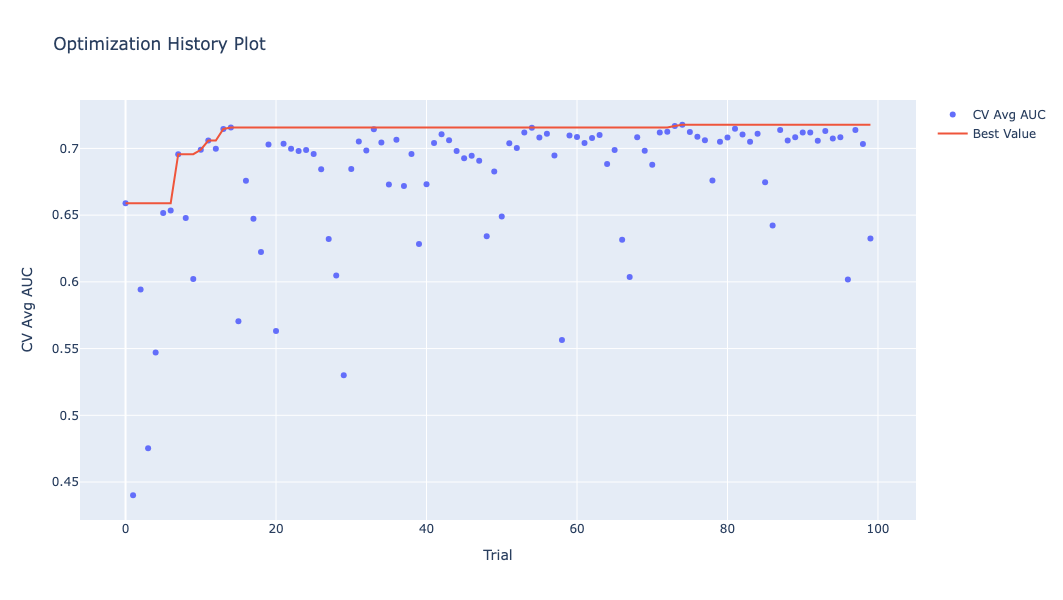

In [1121]:
fig = optuna.visualization.plot_optimization_history(study, target_name='CV Avg AUC')

fig.update_layout(
    autosize=True,
    width=800,
    height=600
)
fig.show()

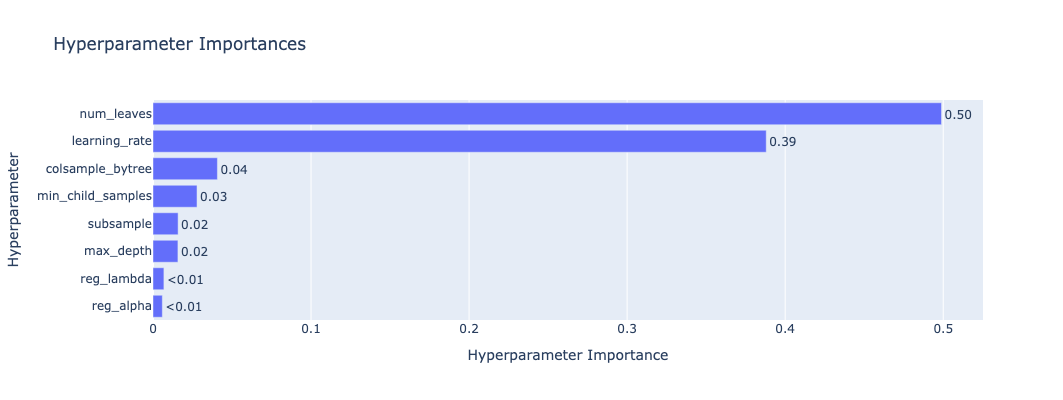

In [1123]:
fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(
    autosize=True,
    width=900,
    height=400
)
fig.show()

In [1125]:
study.best_params

{'learning_rate': 0.09982325130958065,
 'num_leaves': 24,
 'max_depth': 21,
 'min_child_samples': 22,
 'subsample': 0.7496598722291121,
 'colsample_bytree': 0.5196832996117371,
 'reg_alpha': 0.07292322902793114,
 'reg_lambda': 0.05241872013079379}

In [86]:
# Train final model with best parameters
best_params = study.best_params
final_model = LGBMClassifier(
    objective='multiclass',
    class_weight='balanced',
    **best_params)
final_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3194
[LightGBM] [Info] Number of data points in the train set: 6156, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


LGBMClassifier(class_weight='balanced', colsample_bytree=0.8274179173445502,
               learning_rate=0.09983221813243115, max_depth=26,
               min_child_samples=17, num_leaves=23, objective='multiclass',
               reg_alpha=0.015377757488450378, reg_lambda=0.010174990423434057,
               subsample=0.8539112410455256)

In [88]:
# Predict on the validation set
y_pred = final_model.predict(X_valid)
# Generate classification report and weighted F1 score
classification_rep = classification_report(y_valid, y_pred, target_names=list(category_mapper.keys()))
f1 = f1_score(y_valid, y_pred, average='weighted')

# Print model evaluation metrics
print("Classification Report:\n", classification_rep)
print("\nWeighted F1 Score:", f1)

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.83      0.82      0.82      1271
    Diseased       0.09      0.12      0.10        93
       Pests       0.04      0.04      0.04        94
    Stressed       0.04      0.04      0.04        82

    accuracy                           0.69      1540
   macro avg       0.25      0.25      0.25      1540
weighted avg       0.69      0.69      0.69      1540


Weighted F1 Score: 0.6896513895669801


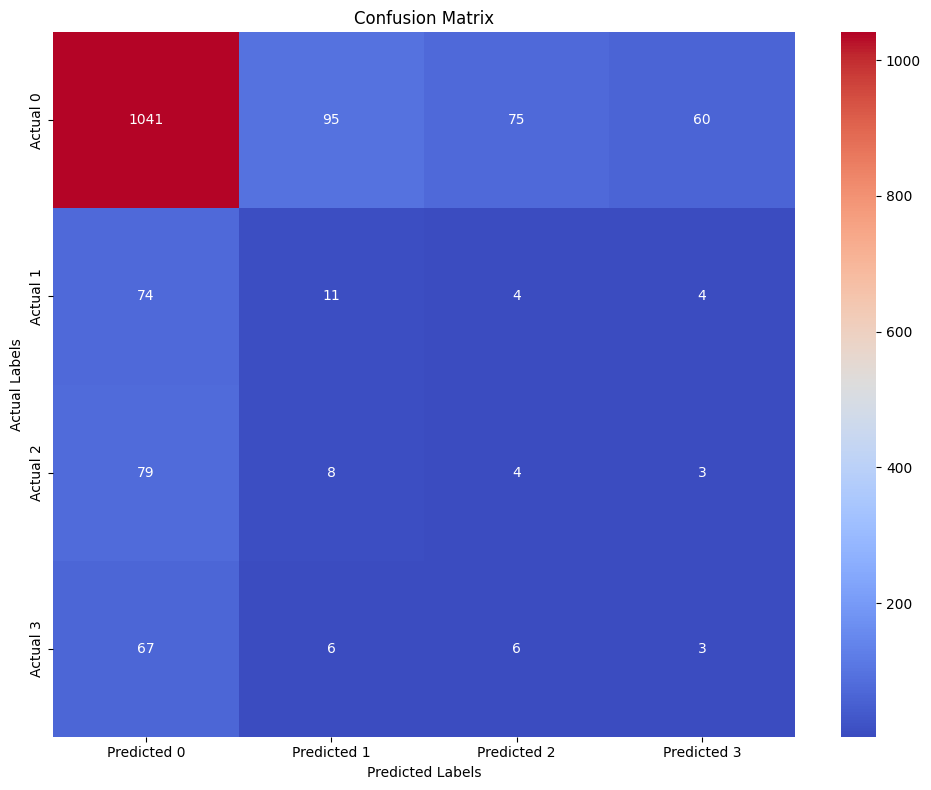

In [90]:
plot_confusion_matrix(y_valid, y_pred)

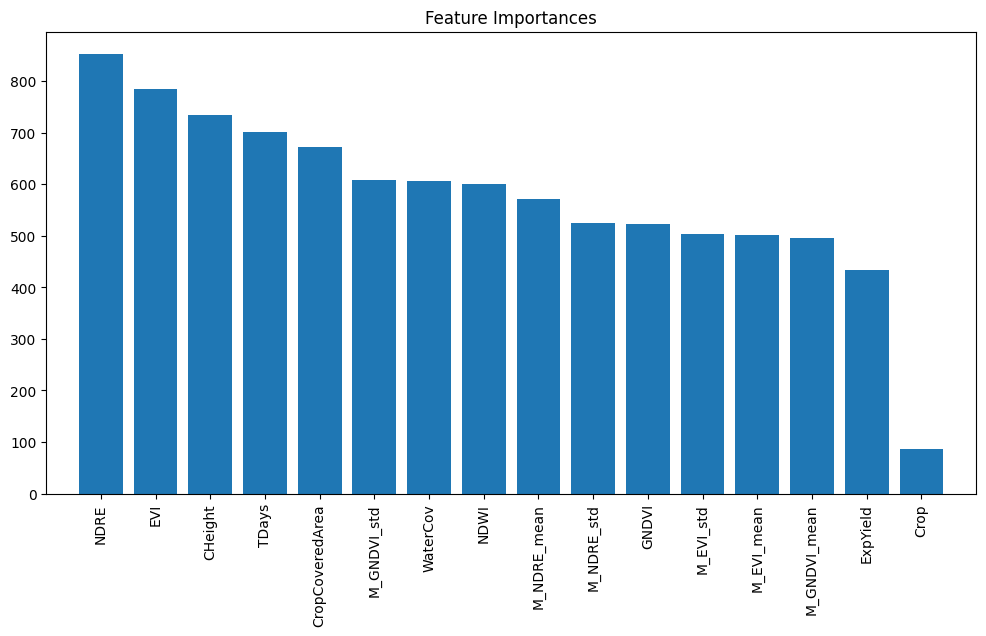

In [1127]:
import matplotlib.pyplot as plt

# Feature Importance Plot
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

## Testing Model & Submission 

### Test data collection

In [1095]:
# Define file paths
qtr_tfile = 'data/Model/Input/test_monthly_indeces.csv'
indices_tfile = 'data/processed/test_s2_indices_v1.csv'

# Prepare the training data

test_df = prepare_indeces_data_stats(qtr_tfile, 
                           indices_tfile,
                           target_substrings=subs_months
                            )

In [1097]:
test_df['D1_EVI'] = test_df['M3_EVI']-test_df['M1_EVI']
test_df['D1_NDRE'] = test_df['M3_NDRE']-test_df['M1_NDRE']
test_df['D1_GNDVI'] = test_df['M3_GNDVI']-test_df['M1_GNDVI']

In [1099]:
test_df = test_df.drop(columns=[col for col in test_df.columns if any(sub in col for sub in subs_cols)])

In [1101]:
# Fill NaN values in all columns with category-wise mean
test_df = test_df.groupby("Crop").apply(
    lambda group: group.fillna(group.mean(numeric_only=True))
).reset_index(drop=True)
test_df.drop(columns=drp_col, inplace=True)
test_df_scl = scaler.fit_transform(test_df)

/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_51283/413057414.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df = test_df.groupby("Crop").apply(


In [1107]:
# Scale model prob
probs_test = lgbm_base_scaled.predict_proba(test_df_scl)
probs_test_df = pd.DataFrame(probs_test, columns=[f'prob_class_{i}' for i in range(probs.shape[1])])
test_df_reset = pd.concat([test_df.reset_index(drop=True), probs_test_df], axis=1)
test_df_reset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2718 entries, 0 to 2717
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Crop             2718 non-null   int64  
 1   CropCoveredArea  2718 non-null   int64  
 2   CHeight          2718 non-null   int64  
 3   WaterCov         2718 non-null   int64  
 4   ExpYield         2718 non-null   int64  
 5   EVI              2718 non-null   float64
 6   MoistureIndex    2718 non-null   float64
 7   NDRE             2718 non-null   float64
 8   TDays            2718 non-null   int64  
 9   M_GNDVI_mean     2718 non-null   float64
 10  M_NDRE_mean      2718 non-null   float64
 11  M_EVI_mean       2718 non-null   float64
 12  M_GNDVI_std      2718 non-null   float64
 13  M_NDRE_std       2718 non-null   float64
 14  M_EVI_std        2718 non-null   float64
 15  D1_EVI           2718 non-null   float64
 16  D1_NDRE          2718 non-null   float64
 17  D1_GNDVI      

### Prediction

In [1137]:
# Predict submission
lg_predictions = lgbm_base.predict(test_df_reset)
lg_predictions

array([0, 0, 0, ..., 0, 0, 0])

In [1139]:
t_data = pd.read_csv(indices_tfile, index_col=0)
t_data['Target'] = lg_predictions
t_data['Target'] = t_data['Target'].astype(int).map(idx_to_category_mapper)
subm_df = t_data[['FarmID', 'Target']]

In [1141]:
subm_df.groupby('Target').count()

FarmID
Target          
Diseased     120
Healthy     2318
Pests        167
Stressed     113

In [1147]:
subm_df.to_csv('data/sub_files/submission_05-01.csv', index=0)

In [1145]:
pd.read_csv('data/sub_files/submission_31-05.csv').groupby('Target').count()

FarmID
Target          
Diseased     254
Healthy     2030
Pests        282
Stressed     152

In [774]:
pd.read_csv('data/sub_files/submission_31-01.csv').groupby('Target').count()

FarmID
Target          
Diseased     103
Healthy     2401
Pests         93
Stressed     121

In [1686]:
pd.read_csv('data/sub_files/submission_27-05.csv').groupby('Target').count()

FarmID
Target          
Diseased     112
Healthy     2420
Pests        108
Stressed      78